---
jupyter: python3
title: "Exemple de Notebook"
format:
  html: default
  pdf: null
---

On donne ci-dessous les paramètres utilisés lors de la simulation comme indiqué dans l'article.      

<h4> Model Parameters : </h4>    

- $S_{0} = 100$
- $r = 0.02 $
- $q = 0 $
- $\sigma = 0.2$
- $h = 0.1 $
-$ \alpha = 0.3$
- $ f = 1.2$
- $ \lambda =0.02 $


<h4> Portfolio Parameters : </h4>  

- $\omega_{1}= 3 , K_{1} = 110 , T_{1} = 1$
- $\omega_{2} = 2 , K_{2} = 115 , T_{2} = 2$
- $\omega_{3} = −2 , K_{3} = 120 , T_{3} = 3$
- $\omega_{4} = 1 , K_{4} = 125 , T_{4} = 4$
- $ \omega_{5} = −1 , K_{5} = 130 , T_{5} = 5$


In [43]:
# Imports

import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.distributions.normal import Normal
    
plt.figure(dpi=600)
plt.rcParams['figure.figsize'] = [12, 8]

alpha = 0.3
h = 0.1
num_samples = 400
N = 100
S0 = 100
r = 0.02
sigma = 0.2
f = 1.2
n_trades = 1
mc_iterations = 500
lambd = 0.02
lambdaC=0.5
R=0.4
q = 0

class CallTrade():
    def __init__(self, K, T,q):
        self.T = T # Maturité
        self.K = K # Strike
        self.q = q # Quantité

    def d_plus(self, St, t):
        return (torch.log(St/self.K) + (r + 0.5 * sigma**2) * torch.tensor(self.T-t)) / (sigma * torch.sqrt(torch.tensor(self.T-t)))

    def d_minus(self, St, t):
        return self.d_plus(St, t) - sigma * torch.sqrt(torch.tensor(self.T-t))

    def delta(self, St, t):
        delta = self.q * Normal(0, 1).cdf(self.d_plus(St, t))
        return delta

    def price(self, St, t):
        return self.q * (St * Normal(0, 1).cdf(self.d_plus(St, t)) - self.K * Normal(0, 1).cdf(self.d_minus(St, t)) * torch.exp(torch.tensor(-r*(self.T-t))))
    def priceforward(self,St,t):
        return self.q * (St - self.K*torch.exp(torch.tensor(-r*(self.T-t))))

class Portfolio():
    def __init__(self, trades=[]):
        self.trades = trades

    def add_trade(self, trade):
        self.trades.append(trade)
        

class ForwardTrade():
    def __init__(self, K, T,q):
        self.T = T # Maturité
        self.K = K # Strike
        self.q = q # Quantité
    def price(self,St,t):
        return self.q* (St - self.K*torch.exp(torch.tensor(-r*(self.T-t))))

    
portfolio2=Portfolio([ForwardTrade(110,1,1)])

portfolio = Portfolio([
    CallTrade(110, 1,1),
    CallTrade(115, 2, 2),
    CallTrade(120, 3, -2),
    CallTrade(125, 4, 1),
    CallTrade(130, 5, -1)
])

reverse_portfolio = Portfolio([
    CallTrade(130, 5, -1),
    CallTrade(125, 4, 1),
    CallTrade(120, 3, -2),
    CallTrade(115, 2, 2),
    CallTrade(110, 1, 3)
])

<Figure size 7200x4800 with 0 Axes>

In [12]:
(1)

1

<h3> Evaluation des Fonctions KVA et FVA dans les modèles : </h3>        

Dans le set-up Markovien, sous le modèle de Black-Scholes, on peut montrer que les fonctions de pricing
$v(t,S_{t})$ et $w(t,S_{t})$ associés respectivement à la
**FVA** et la **KVA** sont telles qu'elles sont solutions du système
d'EDP couplé suivant (dans leur forme la plus générique) :


On note $A^{bs}_{S}v=(r-q)S\frac{\partial{v}}{\partial{S}}+\frac{1}{2}\frac{\partial^{2}{v}}{\partial^{2}{S}}S^{2}\sigma^{2}$

- $v(T,S)=w(T,S)=0  $ sur $]0, \infty[$
- $\frac{\partial{v}}{\partial{t}}+A^{bs}_{S}v+ \lambda(max(\alpha f  \sigma  S  |\frac{\partial{v}}{\partial{S}}- \Delta_{bs} |,w) + v - u_{bs})^{-}-rv=0$ sur $]0,T[x ]0,\infty[$
- $\frac{\partial{w}}{\partial{t}}+A^{bs}_{S}w+ h max(\alpha f \sigma S | \frac{\partial{v}}{\partial{S}}- \Delta_{bs}|,w)-(r+h)w=0$  sur $]0,T[x ]0,\infty[$


Le projet va s'articuler en différentes parties :

- [Dans la partie n°1](#section_1)
, on va s'intéresser à la résolution d'EDPs dans des formes plus simples à l'aide de méthodes de **Deep Learning** afin que nous puissions nous benchmarker avec des méthodes classiques de résolution type **Monte Carlo**.

- [Dans la partie n°2](#section_2) , on va utiliser la méthode dite **Deep Galerkin** afin de résoudre les EDPs dans leur forme la plus générique.




[Partie BONUS](#section_bonus) :     

- On a également tenté d'implémenter la méthode dite **Deep BSDE Solver** par réseaux de neurones présenté dans l'article de **E, W., J. Han, et A. Jentzen** mais on a un problème de stabilité donc on a juste mis le code à titre informatif.




---





In [13]:

def generate_BS_paths(num_samples, N, S0, r,h, sigma, T):
    dt = T / N
    sqrt_dt = np.sqrt(dt)
    paths = np.ones((num_samples, N + 1))*S0
    for i in (range(num_samples)):
        S = S0
        for j in range(1, N + 1):
            t = j * dt
            dW = np.random.normal(0, sqrt_dt)
            S *= np.exp((r - 0.5 * sigma ** 2) * dt + sigma * dW)

            paths[i, j] = S
    return paths


def generate_BS_pathsS0random(num_samples, N, n_trades, r, h, sigma):
    # torch.random.seed()
    Tmax = portfolio.trades[n_trades - 1].T
    S0 = torch.empty(num_samples).uniform_(10, 200).view(-1, 1)
    dt = Tmax / N
    sqrt_dt = np.sqrt(dt)
    paths = np.ones((num_samples, N + 1))
    paths[:,0:1]=S0
    for i in (range(num_samples)):
        S = paths[i,0]
        for j in range(1,N + 1):
            t = j * dt
            dW = np.random.normal(0, sqrt_dt)
            S *= np.exp((r - 0.5 * sigma ** 2) * dt + sigma * dW)
            paths[i, j] = S
    return paths




In [14]:
# Ces méthodes sont pour un S0 unique, les méthodes Monte Carlo Vectorized_Vectorized sont pour faire pareil mais avec un vecteur de S0 différents

# Méthodes vectorisées plus loin

 #Basic Monte-Carlo Forward
"""
def generatePayoff(num_samples, N, n_trades, S0, r, sigma, alpha, h, f):
    Tmax = portfolio.trades[n_trades - 1].T
    grid = np.linspace(0, Tmax, N)
    pas = Tmax/N
    S_val = torch.tensor(generate_BS_paths(num_samples, N, S0, r, h, sigma, Tmax))
    sum = torch.zeros(S_val.shape[0], 1)
    for index, s in (enumerate(grid)):
        deltaS = torch.zeros(S_val.shape[0], 1)
        Ss = S_val[:, index:index + 1]
        for i in range(n_trades):
            current_trade = portfolio.trades[i]
            if s < current_trade.T:
                deltaS += current_trade.delta(Ss, s)
        sum += Ss*torch.abs(deltaS)*np.exp(-(r+h)*(s))*alpha*h*sigma*f
    sum *= pas
    integralvalue=torch.mean(sum)
    return integralvalue


# Basic Monte-Carlo Forward Vectorized
def generatePayoffVectorized(num_samples, N, n_trades, S0, r, sigma, alpha, h, f):
    Tmax = portfolio.trades[n_trades - 1].T
    grid = np.linspace(0, Tmax, N)
    pas = Tmax/N
    S_val = torch.tensor(generate_BS_paths(num_samples, N, S0, r, h, sigma, Tmax))
    sums = torch.zeros(n_trades, S_val.shape[0], 1)
    for index, s in (enumerate(grid)):
        Ss = S_val[:, index:index + 1]
        deltaS = torch.zeros(n_trades, S_val.shape[0], 1)
        for i in range(n_trades):
            for j in range(i + 1):
                current_trade = portfolio.trades[j]
                if s < current_trade.T:
                    deltaS[i] += current_trade.delta(Ss, s)
        sums += Ss*torch.abs(deltaS)*np.exp(-(r+h)*(s))*alpha*h*sigma*f
    sums *= pas
    integralvalue = torch.mean(sums, dim=1)
    return integralvalue

print(generatePayoff(num_samples, N, n_trades, S0, r, sigma, alpha, h, f))
generatePayoffVectorized(num_samples, N, n_trades, S0, r, sigma, alpha, h, f)
""";

# <a name='section_1'></a>

**Partie n°1 : Etude des EDPs simplifiées**

Dans cette partie, on va s'intéresser au couplage n°3 donné dans la liste des projets

On va s'intéresser au couplage n°3 présenté dans l'article :


- $v_{3}(T,s)=w_{3}(T,s)=0  $ sur $]0, \infty[$
- $\frac{\partial{v_{3}}}{\partial{t}}+A^{bs}_{S}v_{3}+ \lambda(\alpha f \sigma S |\Delta_{bs}| -u_{bs})^{-}-rv_{3}=0$ sur $]0,T[x ]0,\infty[ \hspace{0.3 cm} (1) $
- $\frac{\partial{w_{3}}}{\partial{t}}+A^{bs}_{S}w_{3}+ \alpha h f \sigma S |\Delta_{bs}|-(r+h)w_{3}=0$  sur $]0,T[x ]0,\infty[ \hspace{0.3 cm}  (2)$

\
Avec :

- $v_{3}$ qui représente la $FVA$
- $w_{3} $ qui représente la $KVA$

D'après la formule de Feymann-Kac, on sait qu'on peut réecrire les équation n°$2$ et $3$ par :

$w_{3}(t,s)=\mathbb{E}[ \int_{t}^{T} e^{-(r+h)(\tau-t)} \alpha h f  \sigma S_{\tau} |\Delta^{bs}_{\tau}| d\tau| S_{t}=s] $

$v_{3}(t,s)=\mathbb{E}[{\int_{t}^{T} e^{-r(\tau-t)}\lambda (\alpha f \sigma S_{\tau} |\Delta^{bs}_{\tau}- u_{bs})^{-} d\tau} | S_{t}=s]$

On cherche à calculer pour notre besoin $w_{3}(0,S_{0})$ et $v_{3}(0,S_{0})$.


On va chercher à apprendre $w_{3}(0,S_{0})$ et $v_{3}(0,S_{0})$ en utilisant les propriétés de l'espérance conditionnelle c'est à dire comme une solution d'un problème de minimisation de la norme $||.||^{2}$.
Pour se faire on va à la fois générer les inputs du réseau de neurones qui vont être $S_{0}$ qu'on supposera distribué de manière uniforme sur l'intervalle $[10,200]$ et on va également générer ce qui se trouve à l'intérieur de l'espérance c'est à dire pour $w_{3}$ par $  \int_{0}^{T} e^{-(r+h)(\tau-t)} \alpha h f  \sigma S_{\tau} |\Delta^{bs}_{\tau}| d\tau$ et pour $v_{3}$ par $ {\int_{0}^{T} e^{-r(\tau-t)}\lambda (\alpha f \sigma S_{\tau} |\Delta^{bs}_{\tau}- u_{bs})^{-} d\tau}$

On cherche alors à exploiter la structure markovienne du processus $(S_{t})_{t \in [0,T]}$.

On va également benchmarker les résultats du réseau de neurones par rapport aux résultats que l'on aurait obtenu par une approche classique
**Monte-Carlo**.


Dans le calcul des intégrales, on prendra soin de faire attention à la maturité de chacun des calls qui sont présentes dans le portefeuille et donc aux termes $u_{bs}$ et $\Delta_{bs}$ qui subissent des "sauts" lorsqu'un call disparait du portefeuille.



**Implémentation de la KVA** :

 On va générer des échantillons de paire $(S_{0}, \int_{0}^{T} e^{-(r+h)(s-t)} \alpha h f  \sigma S_{s} |\Delta^{bs}_{s}| ds $) (ou en vectorisé des échantillons $(S_{0}, (\int_{0}^{T} e^{-(r+h)(s-t)} \alpha h f  \sigma S_{s} |\Delta^{bs}_{s}| ds)_{1 \leq i \leq n_{trades}} $)</h3>


In [15]:
def generate_S0_KVA(num_samples, N, n_trades, r, sigma, alpha, h, f):
    Tmax = portfolio.trades[n_trades - 1].T
    Trajectories = generate_BS_pathsS0random(num_samples, N, n_trades, r, h, sigma)
    grid = np.linspace(0, Tmax, N)
    pas = Tmax/N
    S_val = torch.tensor(Trajectories, dtype=torch.float32)
    S0random = S_val[:, 0:1]
    sum = torch.zeros(S_val.shape[0], 1)

    for index, s in (enumerate(grid)):
        deltaS = torch.zeros(S_val.shape[0], 1)
        Ss = S_val[:,index:index+1]
        for i in range(n_trades):
            current_trade = portfolio.trades[i]
            if s < current_trade.T:
                deltaS += current_trade.delta(Ss, s)
        sum += Ss*torch.abs(deltaS)*np.exp(-(r+h)*(s))*alpha*h*sigma*f

    sum *= pas

    return S0random, sum

def generate_S0_KVA_Vectorized(num_samples, N, n_trades, r, sigma, alpha, h, f, portfolio):
    Tmax = portfolio.trades[n_trades - 1].T
    Trajectories = generate_BS_pathsS0random(num_samples, N, n_trades, r, h, sigma)
    grid = np.linspace(0, Tmax, N)
    pas = Tmax/N
    S_val = torch.tensor(Trajectories, dtype=torch.float32)
    S0random = S_val[:, 0:1]
    sums = torch.zeros(S_val.shape[0], n_trades, 1)

    for index, s in (enumerate(grid)):
        Ss = S_val[:,index:index+1]
        deltaS = torch.zeros(S_val.shape[0], n_trades, 1)
        for i in range(n_trades):
            for j in range(i + 1):
                current_trade = portfolio.trades[j]
                if s < current_trade.T:
                    #print(deltaS.shape, current_trade.delta(Ss, s).shape)
                    deltaS[:, i, :] += current_trade.delta(Ss, s)
        #print(Ss.shape, sums.shape, deltaS.shape)
        sums += Ss.unsqueeze(-1) * torch.abs(deltaS)*np.exp(-(r+h)*(s))*alpha*h*sigma*f

    sums *= pas

    return S0random, sums

In [16]:
"""
S0_train, payoff_train = generate_S0_KVA(num_samples, N, n_trades, r, sigma, alpha, h, f)
S0_val, payoff_val = generate_S0_KVA(num_samples, N, n_trades, r, sigma, alpha, h, f)
"""
S0_train_vec, payoff_train_vec = generate_S0_KVA_Vectorized(num_samples, N, n_trades, r, sigma, alpha, h, f, portfolio)
S0_val_vec, payoff_val_vec = generate_S0_KVA_Vectorized(num_samples, N, n_trades, r, sigma, alpha, h, f, portfolio)
print(f"Vectorized shapes : S0_train_vec: {S0_train_vec.shape}, payoff_train_vec: {payoff_train_vec.shape}")



Vectorized shapes : S0_train_vec: torch.Size([400, 1]), payoff_train_vec: torch.Size([400, 1, 1])


On présente ci-dessous l'architecture du réseau de neurones que nous avons conservé identique à celle vue lors de la séance de TP.

$y = W_{out} \varphi\left(W_2 \varphi\left(W_1 x + b_1\right) + b_2\right)+b_{out}$ for a given input $x$, where $\varphi : u \mapsto \frac{1}{1+e^{-u}}$ is the sigmoid activation function applied element-wise on vector inputs, $W_1$, $W_2$ and $W_{out}$ are respectively $15\times 1$, $15\times 15$ and $1\times 15$ weight matrices, and $b_1, b_2 \in \mathbb{R}^{15}$ and $b_{out} \in \mathbb{R}$ are biases.

$W_1$, $W_2$, $W_{out}$, $b_1$, $b_2$ and $b_{out}$ are the parameters of the neural network, to be estimated later during training.


In [ ]:

from math import sqrt
from tqdm.notebook import tqdm

class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self, n_trades, X_train, y_train, X_val, y_val):
        super(FeedforwardNeuralNetwork, self).__init__()
        self.W1 = nn.Parameter(sqrt(2/30) * torch.randn((1, 15), dtype=torch.float32))
        self.W2 = nn.Parameter(sqrt(2/16) * torch.randn((15, 15), dtype=torch.float32))
        self.b1 = nn.Parameter(torch.zeros(1, 15, dtype=torch.float32))
        self.b2 = nn.Parameter(torch.zeros(1, 15, dtype=torch.float32))
        # Ajuster la forme de Wout pour avoir une sortie de dimension n_trades
        self.Wout = nn.Parameter(sqrt((2/16)) * torch.randn((15, n_trades), dtype=torch.float32))  # Ajusté pour n_trades
        self.bout = nn.Parameter(torch.zeros(1, n_trades, dtype=torch.float32))  # Ajusté pour n_trades

        self.X_train = X_train
        self.y_train = y_train

        self.X_val = X_val
        self.y_val = y_val

        self.X_train_mean = X_train.mean()
        self.X_train_std = X_train.std()

        self.y_train_mean = y_train.mean()
        self.y_train_var = y_train.var()

        self.X_val_mean = X_val.mean()

    def forward(self, x):
        #print("Input shape : ", x.shape)
        y = torch.sigmoid(torch.sigmoid(x @ self.W1 + self.b1) @ self.W2 + self.b2) @ self.Wout + self.bout
        return y.unsqueeze(-1)

    def predict(self, x):
         return self.forward((x - self.X_train_mean)/self.X_train_std)

    def learn(self, num_epochs=1000, plot=True):

        train_losses = []
        val_losses = []

        # Initialise la barre de progression
        pbar = tqdm(total=num_epochs)

        for epoch in range(num_epochs):
            # Perform the forward pass on the training set
            pred = self.forward((self.X_train - self.X_train_mean) / self.X_train_std)
            train_loss = loss(pred, self.y_train) / self.y_train_var

            # Compute the gradients and update the parameters
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Perform the forward pass on the validation set
            with torch.no_grad():
                pred = self.forward((self.X_val - self.X_val_mean) / self.X_train_std)
                val_loss = loss(pred, self.y_val) / self.y_train_var

            # Met à jour la description de la barre de progression pour cette époque
            pbar.set_description(f"Epoch {epoch + 1}: Train Loss = {train_loss.item():.4f}, Val Loss = {val_loss.item():.4f}")
            pbar.update(1)

            # Record the training and validation losses for plotting
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())

        # Ferme la barre de progression une fois l'entraînement terminé
        pbar.close()

        if plot:
            plt.plot(train_losses, label="Training Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()

KVA_FFNN_model = FeedforwardNeuralNetwork(n_trades, S0_train_vec, payoff_train_vec, S0_val_vec, payoff_val_vec)
optimizer = torch.optim.Adam(KVA_FFNN_model.parameters(), lr=0.01)
loss = nn.MSELoss()

test_index = 2
print("Test de forward :")
print("S0 : ", S0_train_vec[test_index], "\npayoff : ", payoff_train_vec[test_index])
print()
print("model(X_test) output shape = ", KVA_FFNN_model.forward(S0_train_vec).shape)
print("model(X_test) output example = ", KVA_FFNN_model.forward(S0_train_vec[test_index]))
print()
print("X Train shape : ", S0_train_vec.shape)
print("Y Train shape : ", payoff_train_vec.shape)
#print("Y : ", payoff_train_vec)


Test de forward :
S0 :  tensor([50.2471]) 
payoff :  tensor([[0.0232],
        [0.0075],
        [0.0244],
        [0.0191],
        [0.0186]])

model(X_test) output shape =  torch.Size([400, 5, 1])
model(X_test) output example =  tensor([[[ 0.8513],
         [-2.0081],
         [ 0.9376],
         [-1.4511],
         [-0.7377]]], grad_fn=<UnsqueezeBackward0>)

X Train shape :  torch.Size([400, 1])
Y Train shape :  torch.Size([400, 5, 1])


  0%|          | 0/1000 [00:00<?, ?it/s]

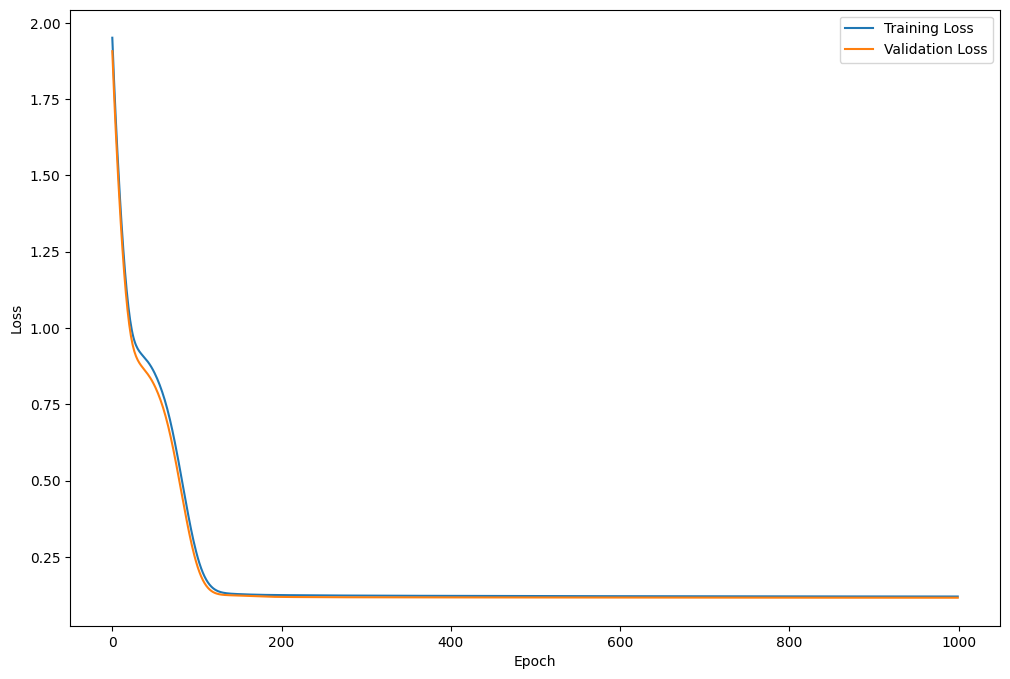

In [ ]:
KVA_FFNN_model.learn(1000)

In [ ]:
# Ce réseau était adapté pour sortir un output de shape 1, le nouveau réseau sort un output de shape n_trades

"""
from math import sqrt

class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self):
        super(FeedforwardNeuralNetwork, self).__init__()
        self.Wout = torch.nn.Parameter(sqrt((2/16))*torch.randn((15,1),dtype=torch.float32))
        self.W1=torch.nn.Parameter(sqrt(2/30)*torch.randn((1,15),dtype=torch.float32))
        self.W2=torch.nn.Parameter(sqrt(2/16)*torch.randn((15,15),dtype=torch.float32))
        self.b1= torch.nn.Parameter(torch.zeros(1,15,dtype=torch.float32))
        self.b2=torch.nn.Parameter(torch.zeros(1,15,dtype=torch.float32))
        self.bout=torch.nn.Parameter(torch.zeros(1,dtype=torch.float32))# Initialiser de manière aléatoire randn ou avec #empty
        # Initialize weights

    def forward(self, x):
        y = torch.sigmoid(torch.sigmoid(x @ self.W1 + self.b1) @ self.W2+self.b2) @ self.Wout + self.bout
        return y

model=FeedforwardNeuralNetwork()
optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
loss=nn.MSELoss()

num_epochs = 1000
train_losses = []
val_losses = []

S0_train_mean = S0_train.mean() # ... (we want the mean of the inputs here)
S0_train_std =S0_train.std() # ... (we want the stdev of the inputs here)

payoff_train_var = payoff_train.var() # ... (we want the variance of the responses here)

from tqdm.notebook import tqdm

# Initialise la barre de progression
pbar = tqdm(total=num_epochs)

for epoch in range(num_epochs):
    # Perform the forward pass on the training set
    pred = model((S0_train - S0_train_mean) / S0_train_std)
    train_loss = loss(pred, payoff_train) / payoff_train_var

    # Compute the gradients and update the parameters
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Perform the forward pass on the validation set
    with torch.no_grad():
        pred = model((S0_val - S0_train_mean) / S0_train_std)
        val_loss = loss(pred, payoff_val) / payoff_train_var

    # Met à jour la description de la barre de progression pour cette époque
    pbar.set_description(f"Epoch {epoch + 1}: Train Loss = {train_loss.item():.4f}, Val Loss = {val_loss.item():.4f}")
    pbar.update(1)

    # Record the training and validation losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

# Ferme la barre de progression une fois l'entraînement terminé
pbar.close()

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
""";

In [64]:
from tqdm.notebook import tqdm

"""
TruePrice = []
for element in tqdm(S0_val_vec):
    payoff = generatePayoffVectorized(num_samples, N, n_trades, element.item(), r, sigma, alpha, h, f)
    TruePrice.append(payoff)

# Empiler les tenseurs le long d'une nouvelle dimension pour créer un tenseur global
TruePrice_tensor = torch.stack(TruePrice, dim=0)
"""

import torch

# Au lieu de prendre un scalaire S0, on donne un vecteur, chaque S0 va générer num_samples paths
def generate_BS_paths_Vectorized(num_samples, N, S0_vec, r, h, sigma, T):
    dt = T / N
    sqrt_dt = torch.sqrt(torch.tensor(dt, device=S0_vec.device))
    batch_size = S0_vec.size(0)

    # Initialiser les chemins. Note: Nous voulons la forme finale (batch_size, num_samples, N+1, 1)
    # Nous allons d'abord créer les chemins comme (batch_size, num_samples, N+1) puis ajouter la dimension à la fin
    paths = torch.zeros(batch_size, num_samples, N + 1, device=S0_vec.device)

    # Répliquer S0 pour chaque ensemble de num_samples chemins
    paths[:, :, 0] = S0_vec.repeat(1, num_samples)

    # Générer dW une fois pour tous les chemins pour une efficacité accrue
    dW = torch.randn(batch_size, num_samples, N, device=S0_vec.device) * sqrt_dt

    # Calculer les chemins
    for j in range(1, N + 1):
        paths[:, :, j] = paths[:, :, j-1] * torch.exp((r - 0.5 * sigma ** 2) * dt + sigma * dW[:, :, j-1])

    # Ajouter une dimension à la fin pour correspondre à la forme souhaitée (batch_size, num_samples, N+1, 1)
    paths = paths.unsqueeze(-1)
    return paths


# Basic Monte-Carlo Forward Vectorized
def generatePayoffKVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_vec, r, sigma, alpha, h, f):
    Tmax = portfolio.trades[n_trades - 1].T
    grid = np.linspace(0, Tmax, N)
    pas = Tmax/N
    S_values = generate_BS_paths_Vectorized(mc_iterations, N, S0_vec, r, h, sigma, Tmax)
    sums = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)

    for index, s in (enumerate(grid)):
        Ss = S_values[:, :, index]
        deltaS = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)

        for i in range(n_trades):
            for j in range(i + 1):
                current_trade = portfolio.trades[j]
                if s < current_trade.T:
                    deltaS[:, :, i] += current_trade.delta(Ss, s)
        exp_component = np.exp(-(r + h) * s)

        sums += Ss.unsqueeze(-1) * torch.abs(deltaS) * exp_component * alpha * h * sigma * f

    sums *= pas
    integralvalue = torch.mean(sums, dim=1)
    return integralvalue

MC_KVA = generatePayoffKVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
MC_KVA.shape




torch.Size([400, 5, 1])

In [65]:
MC_KVA

tensor([[[3.5859e-02],
         [3.2160e-01],
         [2.7668e-01],
         [3.3637e-01],
         [4.1738e-01]],

        [[1.0345e+00],
         [4.7084e+00],
         [2.7698e+00],
         [4.3573e+00],
         [3.3965e+00]],

        [[3.2615e-03],
         [7.7203e-02],
         [1.1787e-01],
         [1.0145e-01],
         [1.9957e-01]],

        ...,

        [[6.6931e-01],
         [3.0053e+00],
         [1.8613e+00],
         [2.8211e+00],
         [2.2727e+00]],

        [[8.1425e-01],
         [3.6351e+00],
         [2.1782e+00],
         [3.3691e+00],
         [2.6722e+00]],

        [[5.8913e-01],
         [2.6578e+00],
         [1.6201e+00],
         [2.4753e+00],
         [1.9978e+00]]])

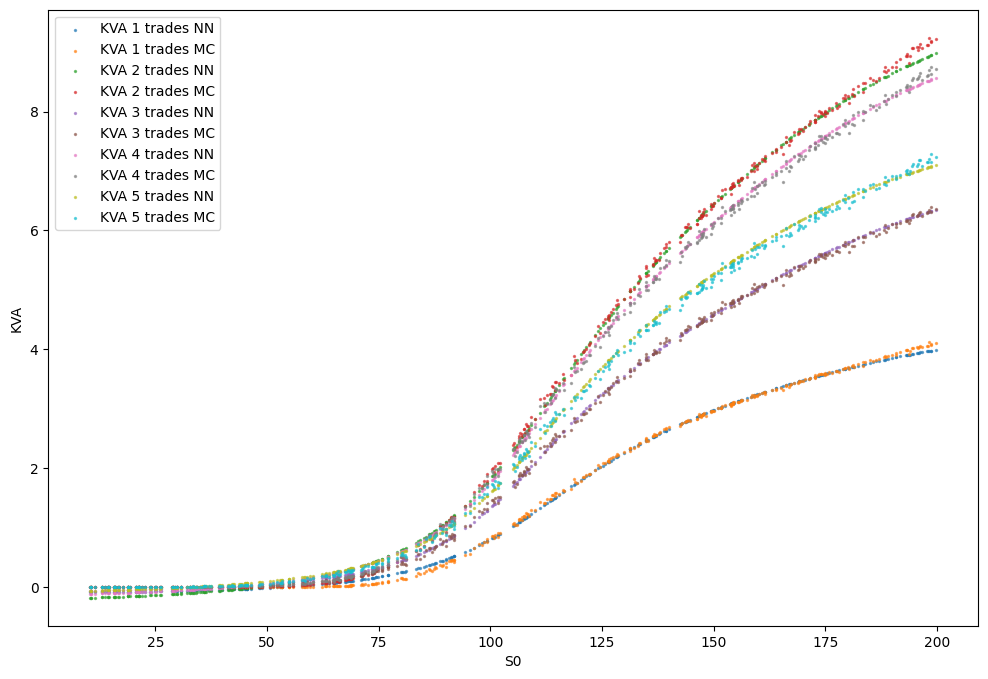

In [ ]:
with torch.no_grad():
    pred = KVA_FFNN_model.predict(S0_val_vec)

for i in range(n_trades):
    plt.scatter(S0_val_vec.numpy(), pred[:, i].numpy(), s=2, alpha=0.6, label=f'KVA {i+1} trades NN')
    plt.scatter(S0_val_vec.numpy(), MC_KVA[:, i], s=2, alpha=0.6, label=f'KVA {i+1} trades MC')
    plt.xlabel("S0")
    plt.ylabel("KVA")
    plt.legend()
plt.show()

---
<h2>Prédictions pour $S_0 = 100$ et calcul des incréments de KVA</h2>


# <a name='Outputs_KVA'></a>



In [ ]:
S0_test = torch.tensor(100).reshape(1, 1)
import pandas as pd
with torch.no_grad():
    KVA_FFNN_pred = KVA_FFNN_model.predict(S0_test).reshape(n_trades, )

increments = torch.cat((KVA_FFNN_pred[:1], KVA_FFNN_pred[1:] - KVA_FFNN_pred[:-1]))

df = pd.DataFrame({
    "Avec x trades": range(1, n_trades+1),
    "Quantités" : [trade.q for trade in portfolio.trades],
    "Strikes" : [trade.K for trade in portfolio.trades],
    "Maturités" : [trade.T for trade in portfolio.trades],

    "Valeurs absolues de KVA": KVA_FFNN_pred.numpy().flatten(),
    "Incréments": increments.numpy().flatten()
})

df

Avec x trades  Quantités  Strikes  Maturités  Valeurs absolues de KVA  \
0              1          3      110          1                 0.800411   
1              2          2      115          2                 1.820042   
2              3         -2      120          3                 1.334697   
3              4          1      125          4                 1.757197   
4              5         -1      130          5                 1.582033   

   Incréments  
0    0.800411  
1    1.019631  
2   -0.485345  
3    0.422500  
4   -0.175164

from matplotlib import pyplot as plt
df['Avec x trades'].plot(kind='hist', bins=20, title='Avec x trades')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Quantités'].plot(kind='hist', bins=20, title='Quantités')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Strikes'].plot(kind='hist', bins=20, title='Strikes')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Maturités'].plot(kind='hist', bins=20, title='Maturités')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Avec x trades', y='Quantités', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Quantités', y='Strikes', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Strikes', y='Maturités', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Maturités', y='Valeurs absolues de KVA', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Avec x trades']
  ys = series['Quantités']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Avec x trades', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Avec x trades')
_ = plt.ylabel('Quantités')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Avec x trades']
  ys = series['Valeurs absolues de KVA']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Avec x trades', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Avec x trades')
_ = plt.ylabel('Valeurs absolues de KVA')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Avec x trades']
  ys = series['Incréments']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Avec x trades', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Avec x trades')
_ = plt.ylabel('Incréments')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Avec x trades']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Avec x trades'}, axis=1)
              .sort_values('Avec x trades', ascending=True))
  xs = counted['Avec x trades']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Avec x trades', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Avec x trades')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df['Avec x trades'].plot(kind='line', figsize=(8, 4), title='Avec x trades')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Quantités'].plot(kind='line', figsize=(8, 4), title='Quantités')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Strikes'].plot(kind='line', figsize=(8, 4), title='Strikes')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Maturités'].plot(kind='line', figsize=(8, 4), title='Maturités')
plt.gca().spines[['top', 'right']].set_visible(False)

<h1>FFNN avec le portfolio inversé :</h1>

Vectorized shapes : S0_train_vec: torch.Size([400, 1]), payoff_train_vec: torch.Size([400, 5, 1])


  0%|          | 0/1000 [00:00<?, ?it/s]

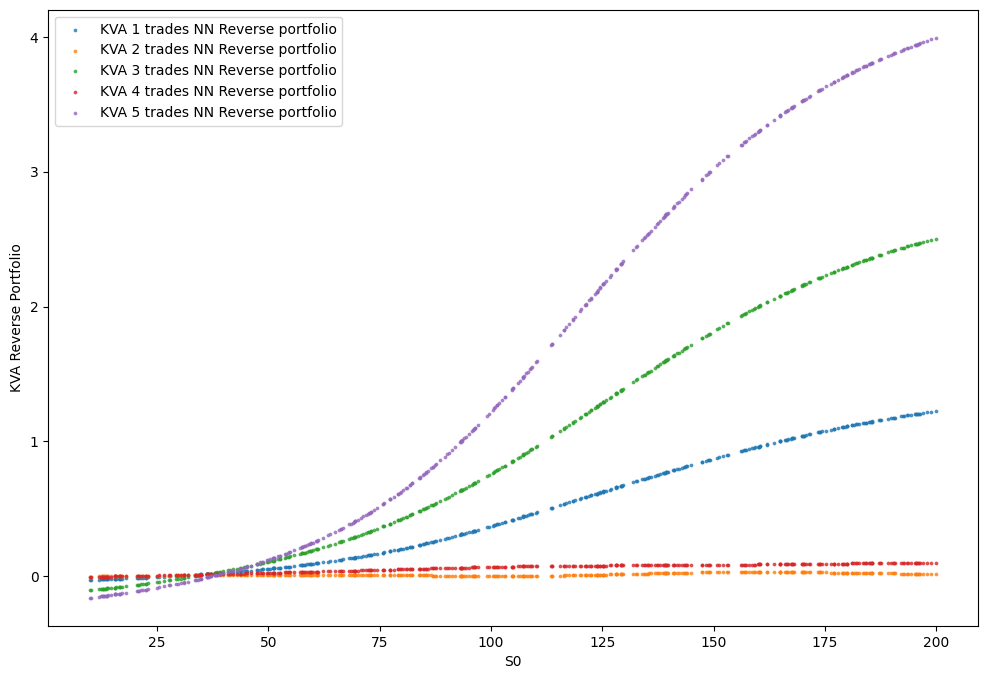

Avec x trades  Quantités  Strikes  Maturités  Valeurs absolues de KVA  \
0              1         -1      130          5                 0.372030   
1              2          1      125          4                 0.002646   
2              3         -2      120          3                 0.758897   
3              4          2      115          2                 0.068980   
4              5          3      110          1                 1.219479   

   Incréments  
0    0.372030  
1   -0.369384  
2    0.756251  
3   -0.689917  
4    1.150499

In [ ]:
S0_train_vec, payoff_train_vec = generate_S0_KVA_Vectorized(num_samples, N, n_trades, r, sigma, alpha, h, f, reverse_portfolio)
S0_val_vec, payoff_val_vec = generate_S0_KVA_Vectorized(num_samples, N, n_trades, r, sigma, alpha, h, f, reverse_portfolio)
print(f"Vectorized shapes : S0_train_vec: {S0_train_vec.shape}, payoff_train_vec: {payoff_train_vec.shape}")

KVA_FFNN_model_rev = FeedforwardNeuralNetwork(n_trades, S0_train_vec, payoff_train_vec, S0_val_vec, payoff_val_vec)
optimizer = torch.optim.Adam(KVA_FFNN_model_rev.parameters(), lr=0.01)
loss = nn.MSELoss()
KVA_FFNN_model_rev.learn(1000, plot=False)


with torch.no_grad():
    pred = KVA_FFNN_model_rev.predict(S0_val_vec)

for i in range(n_trades):
    plt.scatter(S0_val_vec.numpy(), pred[:, i].numpy(), s=3, alpha=0.7, label=f'KVA {i+1} trades NN Reverse portfolio')
    plt.xlabel("S0")
    plt.ylabel("KVA Reverse Portfolio")
    plt.legend()
plt.show()


S0_test = torch.tensor(100).reshape(1, 1)
import pandas as pd
with torch.no_grad():
    KVA_FFNN_pred_rev = KVA_FFNN_model_rev.predict(S0_test).reshape(n_trades, )

increments = torch.cat((KVA_FFNN_pred_rev[:1], KVA_FFNN_pred_rev[1:] - KVA_FFNN_pred_rev[:-1]))

df = pd.DataFrame({
    "Avec x trades": range(1, n_trades+1),
    "Quantités" : [trade.q for trade in reverse_portfolio.trades],
    "Strikes" : [trade.K for trade in reverse_portfolio.trades],
    "Maturités" : [trade.T for trade in reverse_portfolio.trades],

    "Valeurs absolues de KVA": KVA_FFNN_pred_rev.numpy().flatten(),
    "Incréments": increments.numpy().flatten()
})

df

On remarque que les valeurs des incréments ne sont plus les mêmes, l'ordre d'arrivée des trades est impotrant.

**Implémentation de la FVA** :

 On va générer des échantillons de paire $(S_{0}, \int_{0}^{T} e^{-r \tau} \lambda(\alpha f  \sigma S_{\tau} |\Delta^{bs}_{\tau}|-u^{bs}_{\tau})^{-} d\tau$) (ou en vectorisé des échantillons $(S_{0}, \int_{0}^{T} e^{-r \tau} \lambda(\alpha f  \sigma S_{\tau} |\Delta^{bs}_{\tau}|-u^{bs}_{\tau})^{-} d\tau)_{1 \leq i \leq n_{trades}} $)</h3>


**Monte-Carlo FVA :**

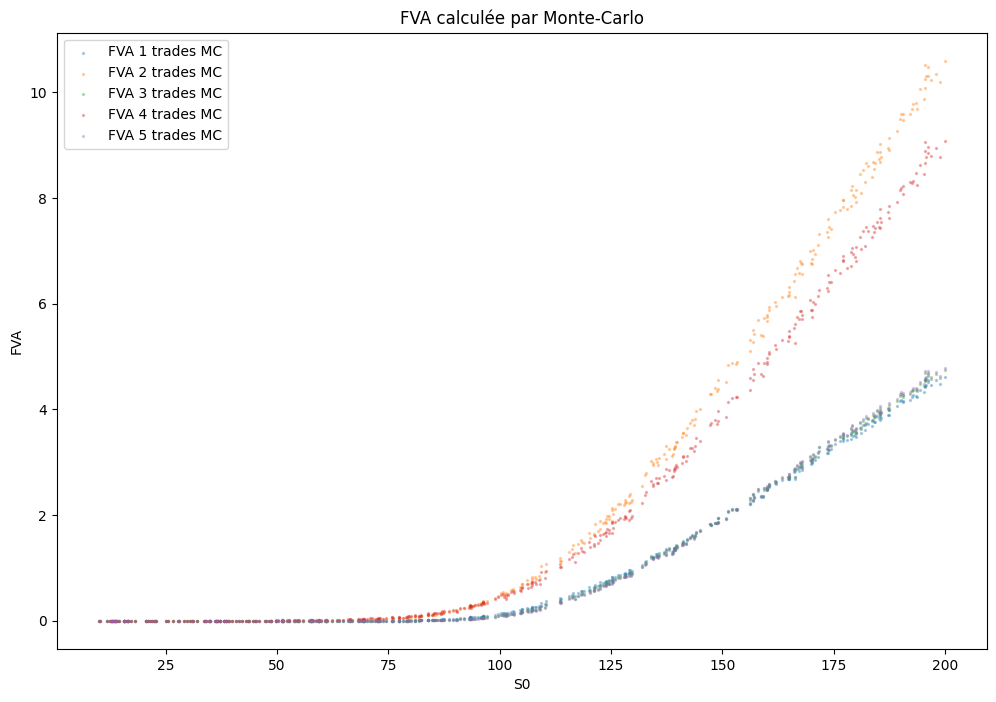

In [ ]:
"""

lambd = 0.1

def generatePayoffFVA(num_samples,N,S0,r,sigma,alpha,h,T,f):
    grid=np.linspace(1/N,T,N)
    pas=T/N
    S_val=torch.tensor(generate_BS_paths(num_samples,N,S0,r,h,sigma,T))
    print(S_val)
    sum=torch.zeros(S_val.shape[0],1)
    for index,value in (enumerate(grid)):
        Ss = S_val[:,index:index+1]

        PrixBS = Portfolio[1][0]*(Ss*Nd1 - Portfolio[1][1]*np.exp(-r*(T-value))*Nd2)
        deltaS=torch.abs(torch.tensor(Portfolio[1][0]*stats.norm.cdf(d1.numpy())))
        sum+=np.exp(-(r)*(value))*lambd*neg(alpha*h*f*sigma*Ss*deltaS-PrixBS)
    sum=sum*pas
    integralvalue=torch.mean(sum)
    return integralvalue
"""

neg = lambda x: torch.where(x < 0, -x, torch.zeros_like(x))

# Basic Monte-Carlo Forward Vectorized
def generatePayoffFVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_vec, r, sigma, alpha, h, f):
    Tmax = portfolio.trades[n_trades - 1].T
    grid = np.linspace(0, Tmax, N)
    pas = Tmax/N
    S_values = generate_BS_paths_Vectorized(mc_iterations, N, S0_vec, r, h, sigma, Tmax)
    sums = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)

    for index, s in (enumerate(grid)):
        Ss = S_values[:, :, index]
        deltaS = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)
        prixBS = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)

        for i in range(n_trades):
            for j in range(i + 1):
                current_trade = portfolio.trades[j]
                if s < current_trade.T:
                    # Les quantités sont déjà prises en compte dans la classe CallTrade
                    deltaS[:, :, i] += current_trade.delta(Ss, s)
                    prixBS[:, :, i] += current_trade.price(Ss, s)

        sums += neg(alpha * f * sigma * Ss.unsqueeze(-1) * torch.abs(deltaS) - prixBS) * np.exp((- r) * s) * lambd

    sums *= pas
    integralvalue = torch.mean(sums, dim=1)
    return integralvalue


FVA_MC = generatePayoffFVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)

for i in range(n_trades):
    plt.scatter(S0_val_vec.numpy(), FVA_MC[:, i], s=2, alpha=0.3, label=f'FVA {i+1} trades MC')
    plt.xlabel("S0")
    plt.ylabel("FVA")
    plt.legend()

plt.title("FVA calculée par Monte-Carlo")
plt.show()

In [ ]:


def generate_S0_FVA_Vectorized(num_samples, N, n_trades, r, sigma, alpha, h, f, portfolio):
    Tmax = portfolio.trades[n_trades - 1].T
    Trajectories = generate_BS_pathsS0random(num_samples, N, n_trades, r, h, sigma)
    grid = np.linspace(0, Tmax, N)
    pas = Tmax/N
    S_val = torch.tensor(Trajectories, dtype=torch.float32)
    S0random = S_val[:, 0:1]
    sums = torch.zeros(S_val.shape[0], n_trades, 1)

    for index, s in (enumerate(grid)):
        Ss = S_val[:,index:index+1]
        deltaS = torch.zeros(S_val.shape[0], n_trades, 1)
        prixBS = torch.zeros(S_val.shape[0], n_trades, 1)
        for i in range(n_trades):
            for j in range(i + 1):
                current_trade = portfolio.trades[j]
                if s < current_trade.T:
                    deltaS[:, i, :] += current_trade.delta(Ss, s)
                    prixBS[:, i, :] += current_trade.price(Ss, s)
        sums += neg(alpha * f * sigma * Ss.unsqueeze(-1) * torch.abs(deltaS) - prixBS) * np.exp((- r) * s) * lambd

    sums *= pas

    return S0random, sums

In [ ]:
#S0_train,payoff_train=generate_S0_FVA(10000,20,0.02,0.3,0.3,0.1,2,3,"1")
#S0_val,payoff_val=generate_S0_FVA(10000,20,0.02,0.3,0.3,0.1,1,3,"1")

S0_train_vec, payoff_train_vec = generate_S0_FVA_Vectorized(num_samples, N, n_trades, r, sigma, alpha, h, f, portfolio)
S0_val_vec, payoff_val_vec = generate_S0_FVA_Vectorized(num_samples, N, n_trades, r, sigma, alpha, h, f, portfolio)

  0%|          | 0/1000 [00:00<?, ?it/s]

'\n\nmodel=FeedforwardNeuralNetwork()\noptimizer=torch.optim.Adam(model.parameters(),lr=0.01)\n#lossfun=nn.MSELoss()\n#loss=lambda y1,y2 : ((y1-y2)**2).mean()\nloss=nn.MSELoss()\n\nnum_epochs = 10000\ntrain_losses = []\nval_losses = []\n\nS0_train_mean = S0_train.mean() # ... (we want the mean of the inputs here)\nS0_train_std =S0_train.std() # ... (we want the stdev of the inputs here)\n\npayoff_train_var =payoff_train.var() # ... (we want the variance of the responses here)\n\nfor epoch in range(num_epochs):\n    # Perform the forward pass on the training set\n    pred = model((S0_train-S0_train_mean)/S0_train_std)# ...\n    train_loss = loss(pred,payoff_train)/payoff_train_var # ...\n\n    # Compute the gradients and update the parameters\n    optimizer.zero_grad()\n    train_loss.backward()\n    optimizer.step()\n\n    # Perform the forward pass on the validation set\n    with torch.no_grad():\n        pred =model((S0_val-S0_train_mean)/S0_train_std) # ...\n        val_loss =loss(p

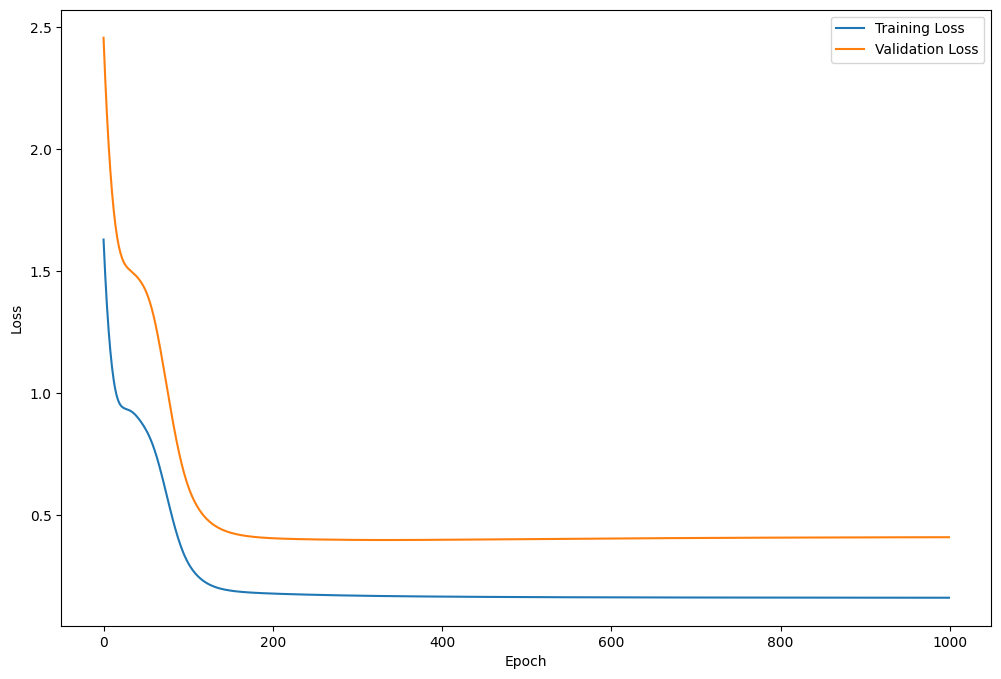

In [ ]:
FVA_FFNN_model = FeedforwardNeuralNetwork(n_trades, S0_train_vec, payoff_train_vec, S0_val_vec, payoff_val_vec)
optimizer = torch.optim.Adam(FVA_FFNN_model.parameters(), lr=0.01)
loss = nn.MSELoss()
FVA_FFNN_model.learn(1000)

"""

model=FeedforwardNeuralNetwork()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
#lossfun=nn.MSELoss()
#loss=lambda y1,y2 : ((y1-y2)**2).mean()
loss=nn.MSELoss()

num_epochs = 10000
train_losses = []
val_losses = []

S0_train_mean = S0_train.mean() # ... (we want the mean of the inputs here)
S0_train_std =S0_train.std() # ... (we want the stdev of the inputs here)

payoff_train_var =payoff_train.var() # ... (we want the variance of the responses here)

for epoch in range(num_epochs):
    # Perform the forward pass on the training set
    pred = model((S0_train-S0_train_mean)/S0_train_std)# ...
    train_loss = loss(pred,payoff_train)/payoff_train_var # ...

    # Compute the gradients and update the parameters
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Perform the forward pass on the validation set
    with torch.no_grad():
        pred =model((S0_val-S0_train_mean)/S0_train_std) # ...
        val_loss =loss(pred,payoff_val)/payoff_train_var # ...

    # Print the loss after each epoch
    print(f"Epoch {epoch+1}: Train Loss = {train_loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

    # Record the training and validation losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
"""

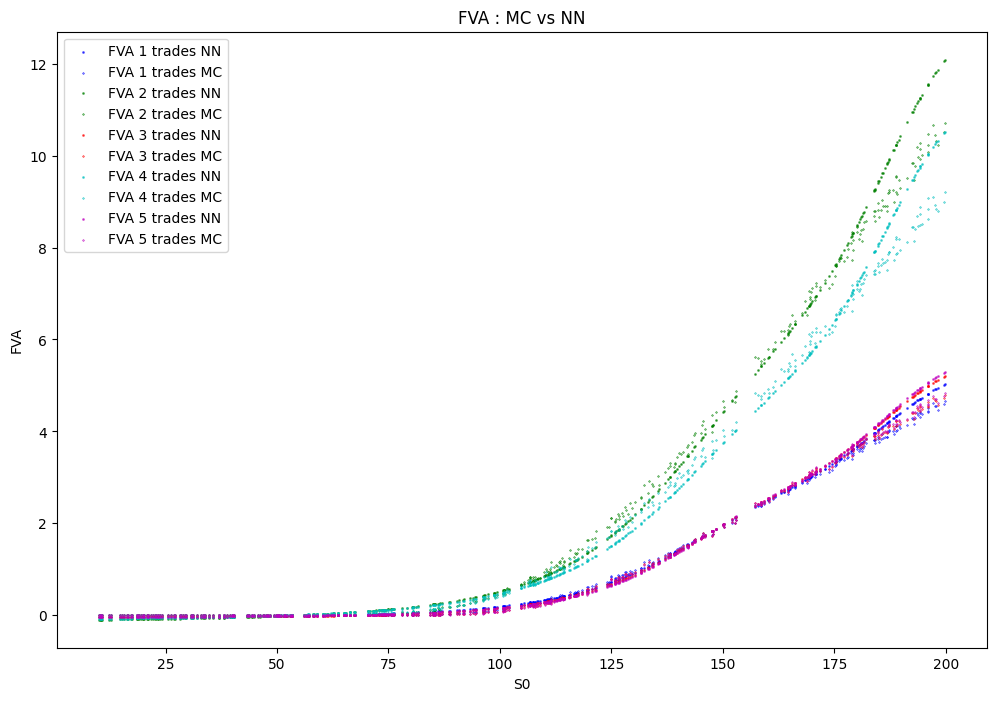

In [ ]:
with torch.no_grad():
    FVA_FFNN_pred = FVA_FFNN_model.predict(S0_val_vec)

FVA_MC = generatePayoffFVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)

from cycler import cycler

# Configure le cycle de couleurs de matplotlib pour qu'il soit infini
plt.rc('axes', prop_cycle=(cycler('color', ['b', 'g', 'r', 'c', 'm', 'y', 'k'])))

for i in range(n_trades):
    # Récupère la couleur actuelle dans le cycle
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.scatter(S0_val_vec.numpy(), FVA_FFNN_pred[:, i], color=color, s=1, alpha=0.6, label=f'FVA {i+1} trades NN')
    plt.scatter(S0_val_vec.numpy(), FVA_MC[:, i], color=color, s=1, alpha=0.5, marker='x', label=f'FVA {i+1} trades MC')
    plt.xlabel("S0")
    plt.ylabel("FVA")
    plt.legend()
plt.title("FVA : MC vs NN")
plt.show()

---
<h2>Prédictions pour $S_0 = 100$ et calcul des incréments de FVA</h2>





In [ ]:
S0_test = torch.tensor(100).reshape(1, 1)
import pandas as pd
with torch.no_grad():
    FVA_FFNN_pred = FVA_FFNN_model.predict(S0_test).reshape(n_trades, )

increments = torch.cat((FVA_FFNN_pred[:1], FVA_FFNN_pred[1:] - FVA_FFNN_pred[:-1]))

df = pd.DataFrame({
    "Avec x trades": range(1, n_trades+1),
    "Quantités" : [trade.q for trade in portfolio.trades],
    "Strikes" : [trade.K for trade in portfolio.trades],
    "Maturités" : [trade.T for trade in portfolio.trades],

    "Valeurs absolues de FVA": FVA_FFNN_pred.numpy().flatten(),
    "Incréments": increments.numpy().flatten()
})

df

Avec x trades  Quantités  Strikes  Maturités  Valeurs absolues de FVA  \
0              1          3      110          1                 0.192386   
1              2          2      115          2                 0.520121   
2              3         -2      120          3                 0.155867   
3              4          1      125          4                 0.468567   
4              5         -1      130          5                 0.155073   

   Incréments  
0    0.192386  
1    0.327735  
2   -0.364255  
3    0.312701  
4   -0.313495

<h1> FVA reverse portfolio : </h1>

Vectorized shapes : S0_train_vec: torch.Size([400, 1]), payoff_train_vec: torch.Size([400, 5, 1])


  0%|          | 0/1000 [00:00<?, ?it/s]

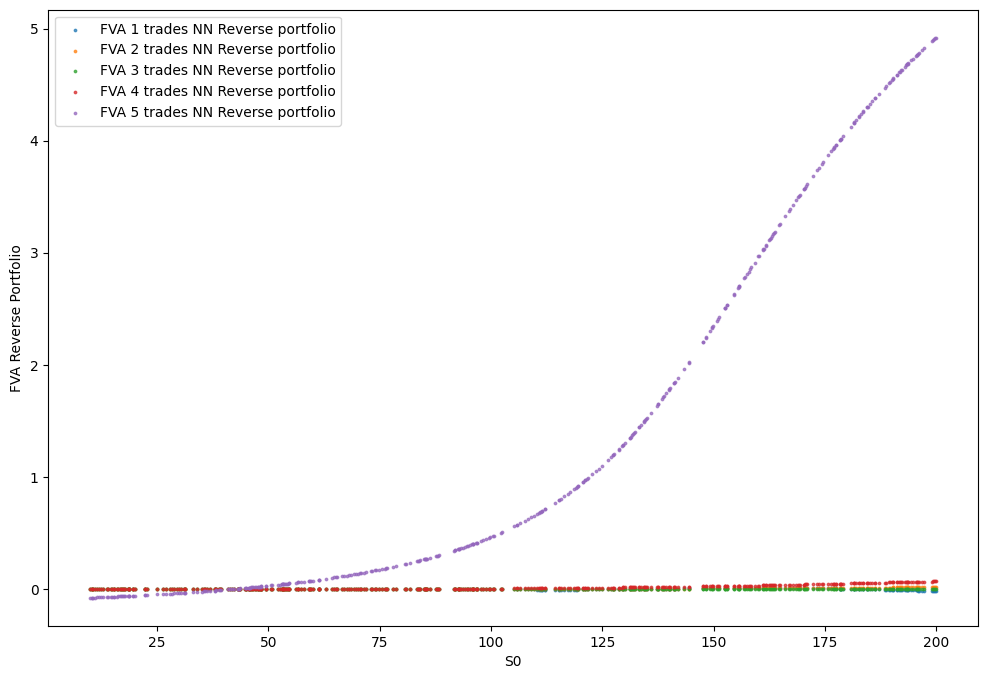

Avec x trades  Quantités  Strikes  Maturités  Valeurs absolues de KVA  \
0              1         -1      130          5                -0.004658   
1              2          1      125          4                -0.000625   
2              3         -2      120          3                -0.001870   
3              4          2      115          2                 0.002264   
4              5          3      110          1                 0.463384   

   Incréments  
0   -0.004658  
1    0.004033  
2   -0.001245  
3    0.004134  
4    0.461121

In [ ]:
S0_train_vec, payoff_train_vec = generate_S0_FVA_Vectorized(num_samples, N, n_trades, r, sigma, alpha, h, f, reverse_portfolio)
S0_val_vec, payoff_val_vec = generate_S0_FVA_Vectorized(num_samples, N, n_trades, r, sigma, alpha, h, f, reverse_portfolio)
print(f"Vectorized shapes : S0_train_vec: {S0_train_vec.shape}, payoff_train_vec: {payoff_train_vec.shape}")

FVA_FFNN_model_rev = FeedforwardNeuralNetwork(n_trades, S0_train_vec, payoff_train_vec, S0_val_vec, payoff_val_vec)
optimizer = torch.optim.Adam(FVA_FFNN_model_rev.parameters(), lr=0.01)
loss = nn.MSELoss()
FVA_FFNN_model_rev.learn(1000, plot=False)


with torch.no_grad():
    pred = FVA_FFNN_model_rev.predict(S0_val_vec)

for i in range(n_trades):
    plt.scatter(S0_val_vec.numpy(), pred[:, i].numpy(), s=3, alpha=0.7, label=f'FVA {i+1} trades NN Reverse portfolio')
    plt.xlabel("S0")
    plt.ylabel("FVA Reverse Portfolio")
    plt.legend()
plt.show()


S0_test = torch.tensor(100).reshape(1, 1)
import pandas as pd
with torch.no_grad():
    FVA_FFNN_pred_rev = FVA_FFNN_model_rev.predict(S0_test).reshape(n_trades, )

increments = torch.cat((FVA_FFNN_pred_rev[:1], FVA_FFNN_pred_rev[1:] - FVA_FFNN_pred_rev[:-1]))

df = pd.DataFrame({
    "Avec x trades": range(1, n_trades+1),
    "Quantités" : [trade.q for trade in reverse_portfolio.trades],
    "Strikes" : [trade.K for trade in reverse_portfolio.trades],
    "Maturités" : [trade.T for trade in reverse_portfolio.trades],

    "Valeurs absolues de KVA": FVA_FFNN_pred_rev.numpy().flatten(),
    "Incréments": increments.numpy().flatten()
})

df

**Analyse des Résultats :**

- On a visiblement une assez bonne efficacité sur l'apprentissage du réseau pour apprendre les fonctions $w_{3}$ et $v_{3}$ lorsqu'elles sont benchmarkés par la méthode Monte-Carlo.

- On voit comme attendu que l'ordre d'arrivée des trades dans le portefeuille a un réel impact sur les montants de KVA et de FVA ce qui n'est pas $fair$ pour client.


<a name='section_2'></a>

**Partie n°2 : Etude des EDPs plus complexes via la méthode Deep Galerkin**

On va s'intéresser ici aux équations suivantes les plus génériques  

- $v(T,S)=w(T,S)=0  $ sur $]0, \infty[$
- $\frac{\partial{v}}{\partial{t}}+A^{bs}_{S}v+ \lambda(u_{bs}-v-\alpha f \sigma S |\Delta_{bs} -\frac{\partial{v}}{\partial{S}}|^{+}-rv=0$ sur $]0,T[\times  ]0,\infty[$
- $\frac{\partial{w}}{\partial{t}}+A^{bs}_{S}w+ \alpha h f \sigma S |\Delta_{bs}-\frac{\partial{v}}{\partial{S}}|-(r+h)w=0$  sur $]0,T[ \times ]0,\infty[$

** Idée de la Méthode :**

Comme $v$ et $w$ sont solutions de l'EDP avec ces conditions terminales, un objectif naturel est de vouloir que l'on soit pour tout couple $(t,S_{t}) \in ]0,T[ \times ]0,\infty[$, que l'approximation de notre solution vérifie la condition terminale ainsi que l'EDP. Pour celà, on va approximer notre solution par un réseau de neurones que l'on notera $U^{v}_{\theta}$ avec $\theta$ l'ensemble des paramètres de notre réseau de neurones. Une idée naturelle est donc de construire $U^{v}_{\theta} \approx v$ et pour celà on va chercher à minimiser la fonction de perte suivante :    

$\small J_{v}(\theta)= \mathbb{E}[(\frac{\partial{U^{v}_{\theta}}}{\partial{t}}(\tau,\mathcal{X})+A^{bs}_{S}U^{v}_{\theta}(\tau,\mathcal{X})+ \lambda(u_{bs}-v-\alpha f \sigma S |\Delta_{bs} -\frac{\partial{U^{v}_{\theta}}}{\partial{S}}(\tau,\mathcal{X})|)^{+}-rU^{v}_{\theta}(\tau,\mathcal{X}))^{2}]+ \mathbb{E}[(U^{v}_{\theta}(T,\mathcal{X}))^{2}]$



- On voit que l'on doit définir 2 variables aléatoires $\tau$ et $\mathcal{X}$ qui doivent à priori représenter notre sampling du temps et de l'espace avec $P_{\tau}$ et $P_{\mathcal{X}}$ les lois de probabilités associées à $\tau$ et $\mathcal{X}$. Le choix de ces 2 variables est évidemment critique dans la génération des samplings d'entraînement du réseau de neurones car ces derniers seront simulés selon la loi $P_{\tau} ⊗ P_{\mathcal{X}}$.

- Le premier terme correspond au fait que le réseau de neurones $U_{\theta}$ doit vérifier l'EDP en tout point $(t,S_{t}) \in ]0,T[ \times ]0,\infty[$

- Le second terme correspond au fait que le réseau de neurones doit vérifier la condition terminale en tout point $S \in ]0,\infty[$

De même, lorsqu'on a des EDPs couplés à résoudre comme c'est le cas ici , on peut également définir :



Dès lors, on va donc initialiser 1 réseau de neurones pour approximer $v$ que l'on a noté $U^{v}_{\theta_{1}}$ et 1 second réseau de neurones $U^{w}_{\theta_{2}}$. On approxime alors les solutions des EDPs couplés en minimisant  :  

$\small J_{w}(\theta_{1},\theta_{2})= \mathbb{E}[(\frac{\partial{U^{w}_{\theta_{2}}}}{\partial{t}}(\tau,\mathcal{X})+A^{bs}_{S}U^{w}_{\theta_{2}}(\tau,\mathcal{X})+ \alpha h f \sigma S |\Delta_{bs}-\frac{\partial{U^{v}_{\theta_{1}}}}{\partial{S}}(\tau,\mathcal{X})|-(r+h)U^{w}_{\theta_{2}}(\tau,\mathcal{X}))^{2}]+ \mathbb{E}[(U^{w}_{\theta_{2}}(T,\mathcal{X}))^{2}]$

  

$J(\theta_{1},\theta_{2})=J_{w}(\theta_{1},\theta_{2})+J_{v}(\theta_{1},\theta_{2})$

Une solution du couple $(v,w)$ de l'EDP initiale est alors donnée par

$v=U^{v}_{\hat{\theta_{1}}}$ et $w=U^{w}_{\hat{\theta_{2}}}$ avec $(\hat{\theta_{1}},\hat{\theta_{2}})$ solution du problème $\arg\min_{(\theta_{1},\theta_{2})} J(\theta_{1},\theta_{2})$



$\textbf{Remarques : }$

- On approxime les espérances par leurs contreparties empiriques
- Si $S \in (R^{*}_{+})^{n} $ avec $n >>1$, alors il faudrait définir une variable aléatoire $\mathcal{X}$ à valeurs dans $(R^{*}_{+})^{n}$ qui maille "bien" le domaine d'intérêt de notre espace.




**Applications :**

Dans les applications ci-dessous, on va s'intéresser au couplage $w_{3}$ et $v_{3}$ que nous avons résolu dans la partie précédente et nous allons comparer les écarts que nous obtenons avec les EDPs les plus génériques c'est à dire $w$ et $v$. Pour celà, on plotera, le résultat **Monte-Carlo** que nous avons obtenu à la partie précédente (avec la couleur rouge) par rapport aux surfaces que nous avons obtenus via la méthode **Deep Galerkin**.


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
T_max = 1.0
S_max = 200.0
S_min = 20.0
num_t_points = 100
num_s_points = 100
batch_size = 1000  # Ajustez en fonction de la capacité de votre système
epochs = 1000
learning_rate = 1e-2
R=0
lambdaC=0.4
lambdaB=0.1
sb=0.02
sl=0.00

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définition des réseaux de neurones pour v et w
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.fc(x)

v_net = Net().to(device)
#w_net = Net().to(device)

# Fonction pour calculer les dérivées nécessaires
def compute_derivatives(net, S, T):
    S = S.requires_grad_()
    T = T.requires_grad_()
    net_input = torch.cat([T, S], dim=-1)
    output = net(net_input)
    output_grad = torch.autograd.grad(outputs=output, inputs=[T, S], grad_outputs=torch.ones_like(output),
                                      create_graph=True, allow_unused=True)
    d_output_dT = output_grad[0]
    d_output_dS = output_grad[1]

    # Ici, on recalcule output pour d_output_dS pour s'assurer que les gradients sont calculés correctement
    d2_output_dS2 = torch.autograd.grad(outputs=d_output_dS.sum(), inputs=S, create_graph=True)[0]

    return output, d_output_dT, d_output_dS, d2_output_dS2

# Fonction de perte
def loss_fn(S, T, v_net):
    v, dv_dt, dv_dS, d2v_dS2 = compute_derivatives(v_net, S, T)
    #w, dw_dt, dw_dS, d2w_dS2 = compute_derivatives(w_net, S, T)

    A_v = (r - q) * S * dv_dS + 0.5 * sigma ** 2 * S ** 2 * d2v_dS2
    #A_w = (r - q) * S * dw_dS + 0.5 * sigma ** 2 * S ** 2 * d2w_dS2

    prix_bs = portfolio2.trades[0].price(S, T)
    #delta_bs = portfolio.trades[0].delta(S, T)

    #V et W
    #loss_v = torch.mean((dv_dt + A_v + (1-R)*lambdaC*prix_bs - (r+lambdaC )* v)** 2) # CVA
    loss_v = torch.mean((dv_dt + A_v + sb*torch.maximum(prix_bs,torch.tensor(0.0))- sl*torch.maximum(-prix_bs,torch.tensor(0.0))- (r+lambdaC+lambdaB)* v)** 2)
    #loss_w = torch.mean((dw_dt + A_w + h * torch.max(alpha * f * sigma * S * torch.abs(dv_dS - delta_bs), w) - (r + h) * w) ** 2)
    #V3 et W3

    """
    loss_v = torch.mean((dv_dt + A_v + lambda_param * torch.abs((alpha * f * sigma * S * torch.abs(delta_bs) - prix_bs).clamp(max=0)) - r * v) ** 2)
    loss_w = torch.mean((dw_dt + A_w + h * alpha * f * sigma * S * torch.abs(delta_bs) - (r + h) * w) ** 2)
    """

    # Conditions terminales
    loss_terminal_v = torch.mean((v_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1)) ** 2))
    #loss_terminal_w = torch.mean((w_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1)) ** 2))

    return loss_v  + loss_terminal_v

# Préparation des données
T = torch.linspace(0, T_max, num_t_points).to(device)
S = torch.linspace(S_min, S_max, num_s_points).to(device)
T_grid, S_grid = torch.meshgrid(T, S, indexing='ij')
T_flat = T_grid.flatten().unsqueeze(1)  # Vecteur colonne
S_flat = S_grid.flatten().unsqueeze(1)  # Vecteur colonne

# Division en ensembles d'entraînement et de validation
indices = torch.randperm(T_flat.size(0))
train_indices = indices[:int(0.8 * len(indices))]
val_indices = indices[int(0.8 * len(indices)):]

T_train, S_train = T_flat[train_indices], S_flat[train_indices]
T_val, S_val = T_flat[val_indices], S_flat[val_indices]

# Optimiseurs
optimizer = optim.Adam(list(v_net.parameters()), lr=learning_rate)

# Entraînement
train_losses = []
val_losses = []

from tqdm.notebook import tqdm

# Boucle d'entraînement avec tqdm
for epoch in tqdm(range(epochs), desc="Training Progress"):
    optimizer.zero_grad()
    loss_train = loss_fn(S_train, T_train, v_net)
    loss_train.backward()
    optimizer.step()

    # Validation
    loss_val = loss_fn(S_val, T_val, v_net)

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())

    # Affichage périodique dans la barre de progression
    if epoch % 100 == 0 or epoch == epochs - 1:
        tqdm.write(f"Epoch {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")

# Tracé des courbes de perte
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Evolution of the loss during the Learning Process")
plt.legend()
plt.grid()
#plt.savefig("Images/TraingAndLossTestFVAFunctionlambdaC0.4lambdaB0.1sb0.02sl0.png")
plt.show()


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\samy.mekkaoui\AppData\Local\Temp\ipykernel_2664\391294273.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.q* (St - self.K*torch.exp(torch.tensor(-r*(self.T-t))))


Epoch 0, Train Loss: 0.5766, Val Loss: 18.8425
Epoch 100, Train Loss: 0.4687, Val Loss: 0.4921


KeyboardInterrupt: 

In [202]:

"""
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
T_max = 1.0
S_max = 200.0
S_min = 20.0
num_t_points = 100
num_s_points = 100
batch_size = 1000  # Ajustez en fonction de la capacité de votre système
epochs = 1000
learning_rate = 1e-2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définition des réseaux de neurones pour v et w
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.fc(x)

v_net = Net().to(device)
w_net = Net().to(device)

# Fonction pour calculer les dérivées nécessaires
def compute_derivatives(net, S, T):
    S = S.requires_grad_()
    T = T.requires_grad_()
    net_input = torch.cat([T, S], dim=-1)
    output = net(net_input)
    output_grad = torch.autograd.grad(outputs=output, inputs=[T, S], grad_outputs=torch.ones_like(output),
                                      create_graph=True, allow_unused=True)
    d_output_dT = output_grad[0]
    d_output_dS = output_grad[1]

    # Ici, on recalcule output pour d_output_dS pour s'assurer que les gradients sont calculés correctement
    d2_output_dS2 = torch.autograd.grad(outputs=d_output_dS.sum(), inputs=S, create_graph=True)[0]

    return output, d_output_dT, d_output_dS, d2_output_dS2

# Fonction de perte
def loss_fn(S, T, v_net, w_net):
    v, dv_dt, dv_dS, d2v_dS2 = compute_derivatives(v_net, S, T)
    w, dw_dt, dw_dS, d2w_dS2 = compute_derivatives(w_net, S, T)

    A_v = (r - q) * S * dv_dS + 0.5 * sigma ** 2 * S ** 2 * d2v_dS2
    A_w = (r - q) * S * dw_dS + 0.5 * sigma ** 2 * S ** 2 * d2w_dS2

    prix_bs = portfolio.trades[0].price(S, T)
    delta_bs = portfolio.trades[0].delta(S, T)

    #V et W

    loss_v = torch.mean((dv_dt + A_v - r * v + 1 ) ** 2)
    loss_w = torch.mean((dw_dt + A_w + h * torch.max(alpha * f * sigma * S * torch.abs(dw_dS - delta_bs), w) - (r + h) * w) ** 2)

    #V3 et W3

    #loss_v = torch.mean((dv_dt + A_v + lambda_param * torch.abs((alpha * f * sigma * S * torch.abs(delta_bs) - prix_bs).clamp(max=0)) - r * v) ** 2)
    #loss_w = torch.mean((dw_dt + A_w + h * alpha * f * sigma * S * torch.abs(delta_bs) - (r + h) * w) ** 2)


    # Conditions terminales
    loss_terminal_v = torch.mean((v_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1)) ** 2))
    loss_terminal_w = torch.mean((w_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1)) ** 2))

    return loss_v + loss_w + loss_terminal_v + loss_terminal_w

# Préparation des données
T = torch.linspace(0, T_max, num_t_points).to(device)
S = torch.linspace(S_min, S_max, num_s_points).to(device)
T_grid, S_grid = torch.meshgrid(T, S, indexing='ij')
T_flat = T_grid.flatten().unsqueeze(1)  # Vecteur colonne
S_flat = S_grid.flatten().unsqueeze(1)  # Vecteur colonne

# Division en ensembles d'entraînement et de validation
indices = torch.randperm(T_flat.size(0))
train_indices = indices[:int(0.8 * len(indices))]
val_indices = indices[int(0.8 * len(indices)):]

T_train, S_train = T_flat[train_indices], S_flat[train_indices]
T_val, S_val = T_flat[val_indices], S_flat[val_indices]

# Optimiseurs
optimizer = optim.Adam(list(v_net.parameters()) + list(w_net.parameters()), lr=learning_rate)

# Entraînement
train_losses = []
val_losses = []

from tqdm.notebook import tqdm

# Boucle d'entraînement avec tqdm
for epoch in tqdm(range(epochs), desc="Training Progress"):
    optimizer.zero_grad()
    loss_train = loss_fn(S_train, T_train, v_net, w_net)
    loss_train.backward()
    optimizer.step()

    # Validation
    loss_val = loss_fn(S_val, T_val, v_net, w_net)

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())

    # Affichage périodique dans la barre de progression
    if epoch % 100 == 0 or epoch == epochs - 1:
        tqdm.write(f"Epoch {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")

# Tracé des courbes de perte
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

""";


In [129]:
v_net(torch.tensor([0.0,100]).to(device))

tensor([2.0490], grad_fn=<ViewBackward0>)

In [188]:
# Basic Monte-Carlo Forward Vectorized
def generatePayoffFVAForwardVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_vec, r, sigma, alpha, h, f):
    Tmax = portfolio.trades[n_trades - 1].T
    grid = np.linspace(0, Tmax, N)
    pas = Tmax/N
    S_values = generate_BS_paths_Vectorized(mc_iterations, N, S0_vec, r, h, sigma, Tmax)
    sums = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)

    for index, s in (enumerate(grid)):
        Ss = S_values[:, :, index]
        prixBS = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)

        for i in range(n_trades):
            for j in range(i + 1):
                current_trade = portfolio2.trades[j]
                if s < current_trade.T:
                    prixBS[:, :, i] += current_trade.price(Ss, s)
        exp_component = np.exp(-(r + lambdaC+lambdaB) * s)

        sums += (sb * torch.maximum(prixBS,torch.tensor(0.0)) - sl * torch.maximum(-prixBS,torch.tensor(0.0)))*exp_component

    sums *= pas
    integralvalue = torch.mean(sums, dim=1)
    return integralvalue


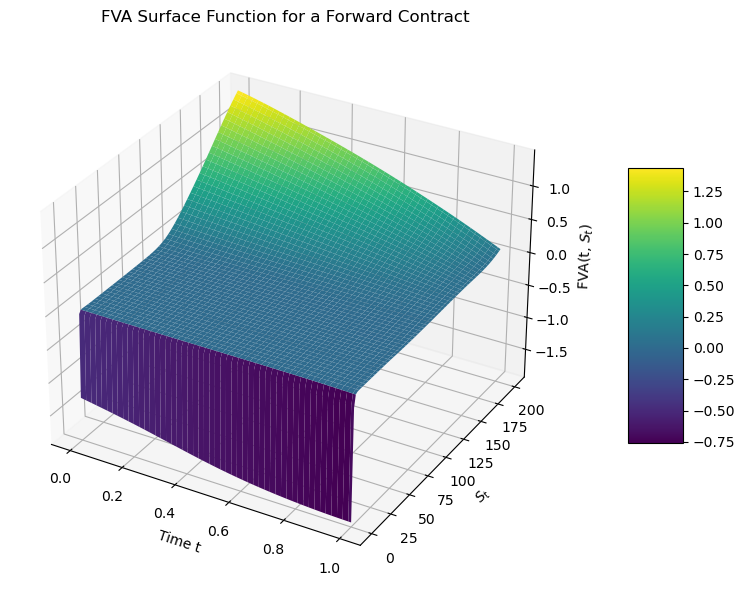

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assurez-vous que les modèles sont en mode évaluation
v_net.eval()
#w_net.eval()

# Génération de la grille de points
T_values = np.linspace(0, T_max, num_t_points)
S_values = np.linspace(0, S_max, num_s_points)
T_grid, S_grid = np.meshgrid(T_values, S_values)
points = torch.tensor(np.stack([T_grid.ravel(), S_grid.ravel()], axis=1), dtype=torch.float32).to(device)

# Évaluation des modèles
with torch.no_grad():
    v_pred = v_net(points).cpu().numpy().reshape(T_grid.shape)
    #w_pred = w_net(points).cpu().numpy().reshape(T_grid.shape)

# Tracé de v
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 1,1, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, v_pred, cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('$S_t$')
ax.set_zlabel(' FVA(t, $S_t$)')
ax.set_title('FVA Surface Function for a Forward Contract')
fig.colorbar(surf, shrink=0.5, aspect=5)

# Tracé de w
#ax = fig.add_subplot(1, 2, 2, projection='3d')
#surf = ax.plot_surface(T_grid, S_grid, w_pred, cmap='viridis')
#ax.set_xlabel('Time t')
#ax.set_ylabel('Spot Price S')
#ax.set_zlabel('w(S, t)')
#ax.set_title('w Function (KVA)')
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.savefig("Images/FVASurfaceProfilelambdaC0.4lambdaB0.1sb0.02sl0.00.png")
plt.show()

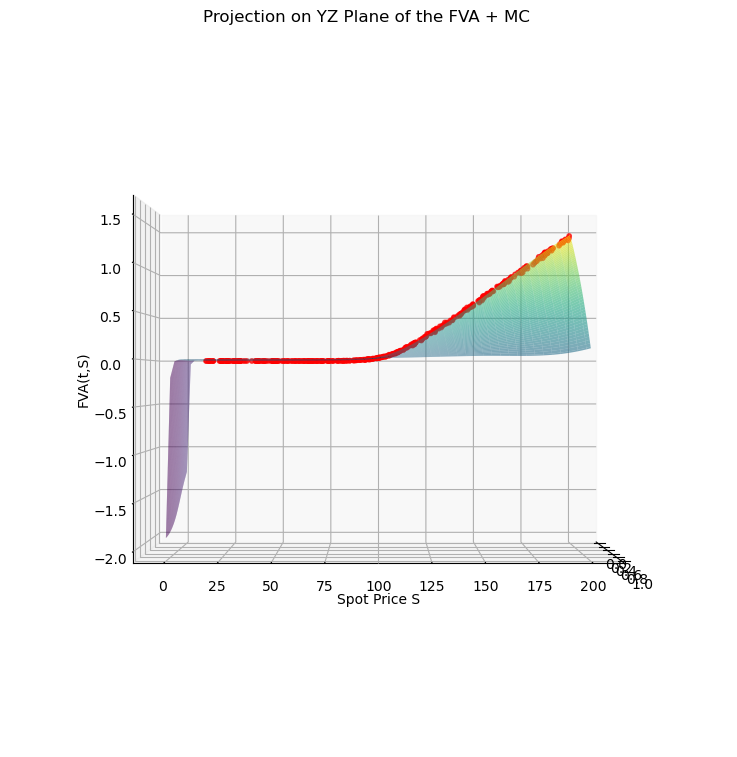

In [213]:

FVA_MC = generatePayoffFVAForwardVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
#ax1 = fig.add_subplot(2, 2, 1, projection='3d')
#surf1 = ax1.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
#ax1.scatter(t_zeros, S0_val_vec.numpy(), CVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
#ax1.set_xlabel('Time t')
#ax1.set_ylabel('$S_t$')
#ax1.set_zlabel('CVA(t, $S_t$)')
#ax1.set_title(' CVA with DGM Method + MC ')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red',s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
#ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('FVA(t,S)')
ax2.set_title('Projection on YZ Plane of the FVA + MC ')
#labels = ["NN Output", "True Value of CVA with MC"]
plt.tight_layout()
plt.savefig("Images/ProjectionFVAWithMClambdaC0.4lambaB0.1sb0.02sl0.0.png")
plt.show()


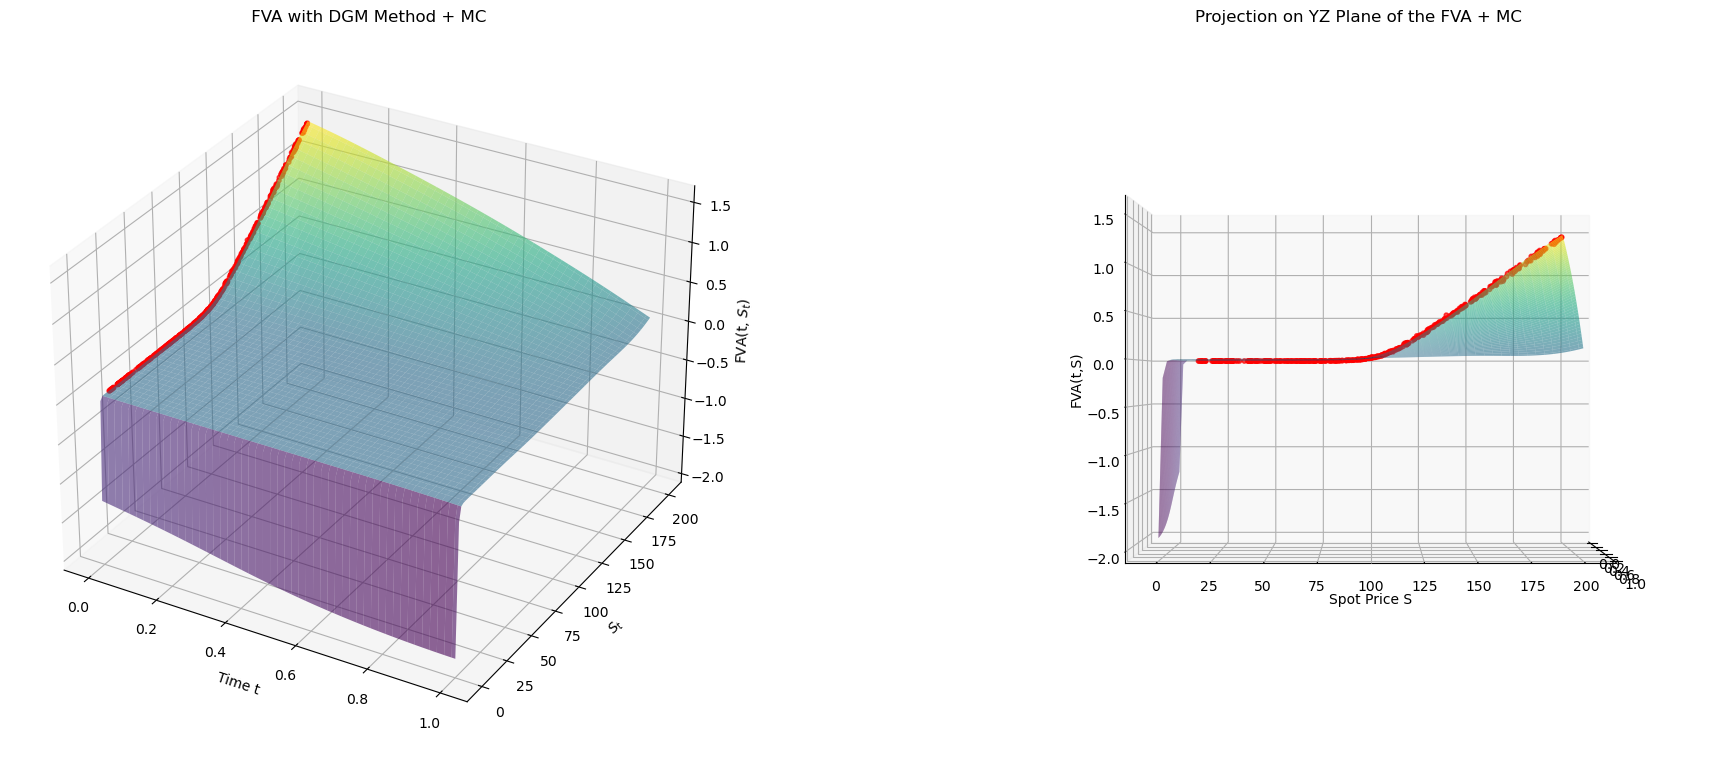

In [214]:

FVA_MC = generatePayoffFVAForwardVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('$S_t$')
ax1.set_zlabel('FVA(t, $S_t$)')
ax1.set_title(' FVA with DGM Method + MC ')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red',s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
#ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('FVA(t,S)')
ax2.set_title('Projection on YZ Plane of the FVA + MC ')
#labels = ["NN Output", "True Value of CVA with MC"]
plt.tight_layout()
#plt.savefig("Images/ProjectionFVAWithMClambdaC0.4lambaB0.1sb0.02sl0.02.png")
plt.show()


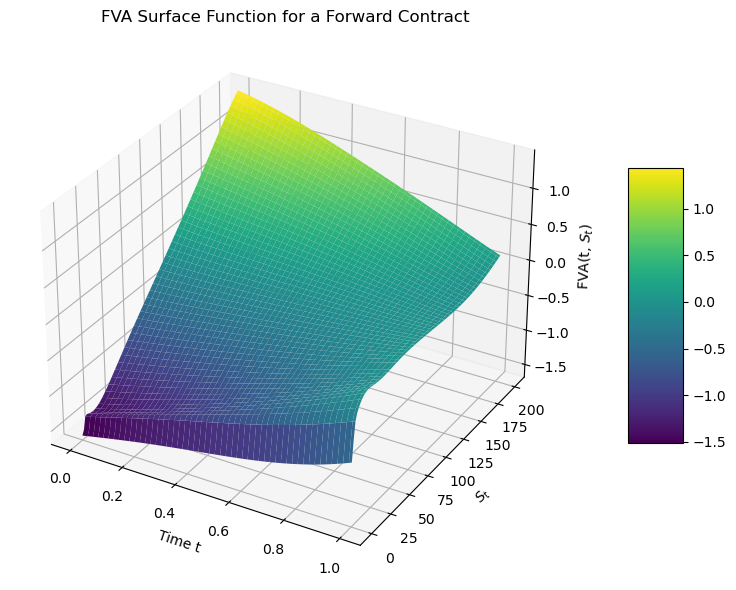

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assurez-vous que les modèles sont en mode évaluation
v_net.eval()
#w_net.eval()

# Génération de la grille de points
T_values = np.linspace(0, T_max, num_t_points)
S_values = np.linspace(0, S_max, num_s_points)
T_grid, S_grid = np.meshgrid(T_values, S_values)
points = torch.tensor(np.stack([T_grid.ravel(), S_grid.ravel()], axis=1), dtype=torch.float32).to(device)

# Évaluation des modèles
with torch.no_grad():
    v_pred = v_net(points).cpu().numpy().reshape(T_grid.shape)
    #w_pred = w_net(points).cpu().numpy().reshape(T_grid.shape)

# Tracé de v
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 1,1, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, v_pred, cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('$S_t$')
ax.set_zlabel(' FVA(t, $S_t$)')
ax.set_title('FVA Surface Function for a Forward Contract')
fig.colorbar(surf, shrink=0.5, aspect=5)

# Tracé de w
#ax = fig.add_subplot(1, 2, 2, projection='3d')
#surf = ax.plot_surface(T_grid, S_grid, w_pred, cmap='viridis')
#ax.set_xlabel('Time t')
#ax.set_ylabel('Spot Price S')
#ax.set_zlabel('w(S, t)')
#ax.set_title('w Function (KVA)')
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.savefig("Images/FVASurfaceProfilelambdaC0.4lambdaB0.1sb0.02sl0.02.png")
plt.show()

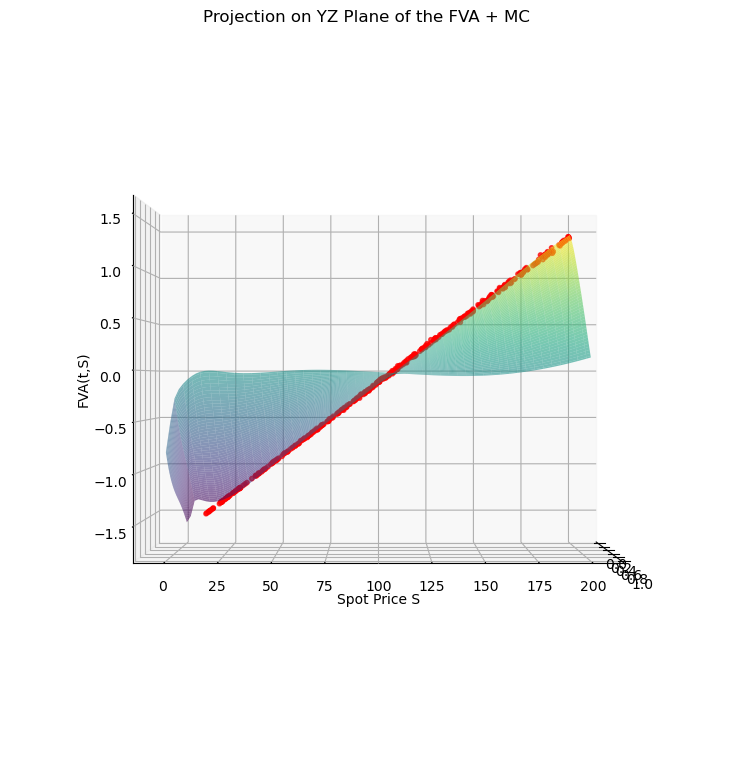

In [196]:

FVA_MC = generatePayoffFVAForwardVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
#ax1 = fig.add_subplot(2, 2, 1, projection='3d')
#surf1 = ax1.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
#ax1.scatter(t_zeros, S0_val_vec.numpy(), CVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
#ax1.set_xlabel('Time t')
#ax1.set_ylabel('$S_t$')
#ax1.set_zlabel('CVA(t, $S_t$)')
#ax1.set_title(' CVA with DGM Method + MC ')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red',s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
#ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('FVA(t,S)')
ax2.set_title('Projection on YZ Plane of the FVA + MC ')
#labels = ["NN Output", "True Value of CVA with MC"]
plt.tight_layout()
plt.savefig("Images/ProjectionFVAWithMClambdaC0.4lambaB0.1sb0.02sl0.02.png")
plt.show()


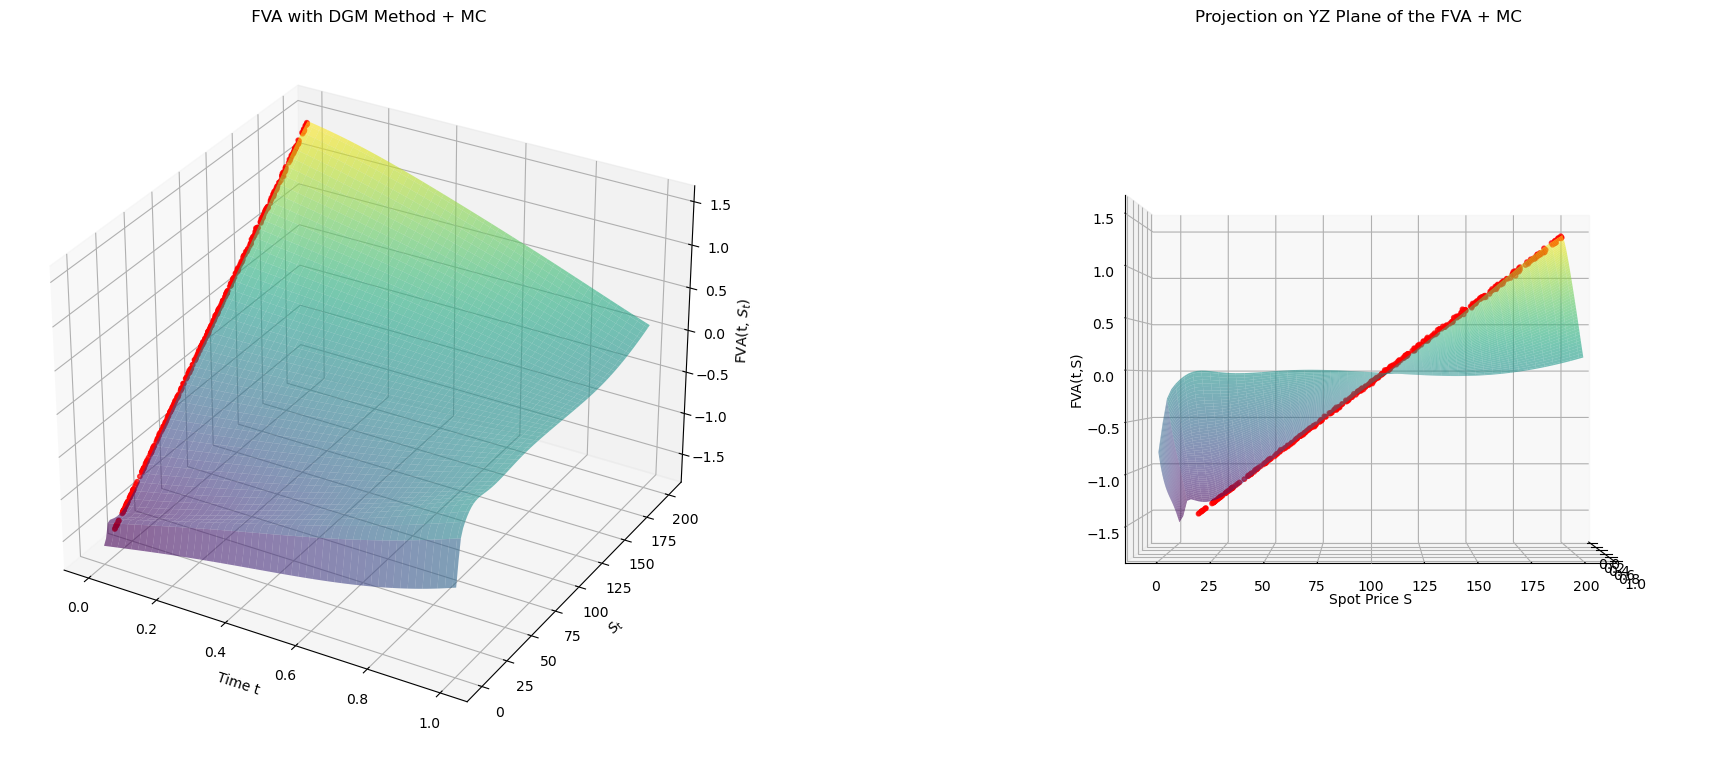

In [197]:

FVA_MC = generatePayoffFVAForwardVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('$S_t$')
ax1.set_zlabel('FVA(t, $S_t$)')
ax1.set_title(' FVA with DGM Method + MC ')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red',s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
#ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('FVA(t,S)')
ax2.set_title('Projection on YZ Plane of the FVA + MC ')
#labels = ["NN Output", "True Value of CVA with MC"]
plt.tight_layout()
#plt.savefig("Images/ProjectionFVAWithMClambdaC0.4lambaB0.1sb0.02sl0.02.png")
plt.show()


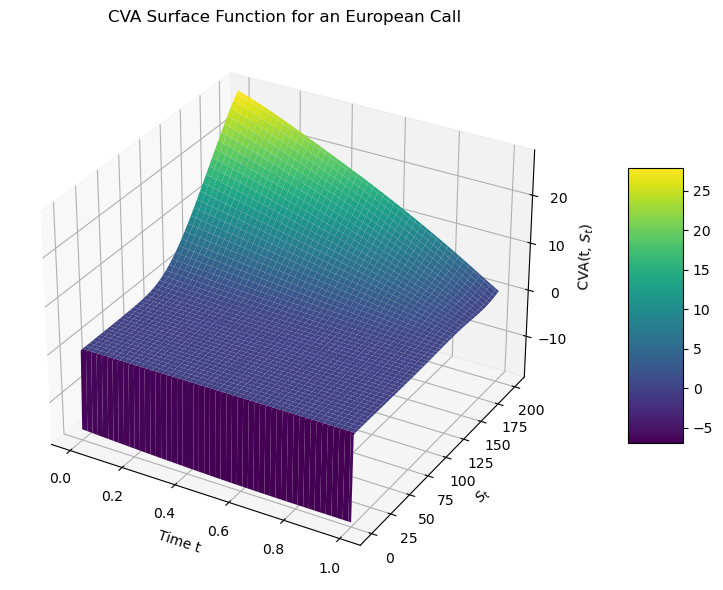

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assurez-vous que les modèles sont en mode évaluation
v_net.eval()
#w_net.eval()

# Génération de la grille de points
T_values = np.linspace(0, T_max, num_t_points)
S_values = np.linspace(0, S_max, num_s_points)
T_grid, S_grid = np.meshgrid(T_values, S_values)
points = torch.tensor(np.stack([T_grid.ravel(), S_grid.ravel()], axis=1), dtype=torch.float32).to(device)

# Évaluation des modèles
with torch.no_grad():
    v_pred = v_net(points).cpu().numpy().reshape(T_grid.shape)
    #w_pred = w_net(points).cpu().numpy().reshape(T_grid.shape)

# Tracé de v
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 1,1, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, v_pred, cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('$S_t$')
ax.set_zlabel(' CVA(t, $S_t$)')
ax.set_title('CVA Surface Function for an European Call')
fig.colorbar(surf, shrink=0.5, aspect=5)

# Tracé de w
#ax = fig.add_subplot(1, 2, 2, projection='3d')
#surf = ax.plot_surface(T_grid, S_grid, w_pred, cmap='viridis')
#ax.set_xlabel('Time t')
#ax.set_ylabel('Spot Price S')
#ax.set_zlabel('w(S, t)')
#ax.set_title('w Function (KVA)')
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.savefig("Images/CVASurfaceProfilelambdaC0.4R0.png")
plt.show()

In [187]:
# Basic Monte-Carlo Forward Vectorized
def generatePayoffCVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_vec, r, sigma, alpha, h, f):
    Tmax = portfolio.trades[n_trades - 1].T
    grid = np.linspace(0, Tmax, N)
    pas = Tmax/N
    S_values = generate_BS_paths_Vectorized(mc_iterations, N, S0_vec, r, h, sigma, Tmax)
    sums = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)

    for index, s in (enumerate(grid)):
        Ss = S_values[:, :, index]
        prixBS = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)

        for i in range(n_trades):
            for j in range(i + 1):
                current_trade = portfolio.trades[j]
                if s < current_trade.T:
                    prixBS[:, :, i] += current_trade.price(Ss, s)
        exp_component = np.exp(-(r + lambdaC) * s)

        sums += (1-R) * torch.abs(prixBS)*lambdaC*exp_component

    sums *= pas
    integralvalue = torch.mean(sums, dim=1)
    return integralvalue


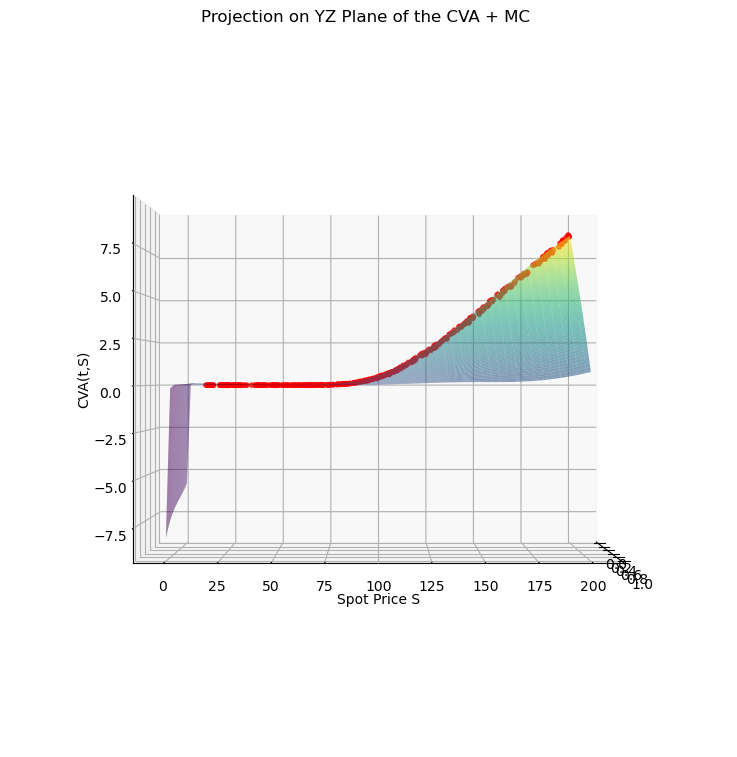

In [150]:

CVA_MC = generatePayoffCVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
#ax1 = fig.add_subplot(2, 2, 1, projection='3d')
#surf1 = ax1.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
#ax1.scatter(t_zeros, S0_val_vec.numpy(), CVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
#ax1.set_xlabel('Time t')
#ax1.set_ylabel('$S_t$')
#ax1.set_zlabel('CVA(t, $S_t$)')
#ax1.set_title(' CVA with DGM Method + MC ')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), CVA_MC[:, 0, 0], color='red',s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
#ax2.set_xlabel('aTime t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('CVA(t,S)')
ax2.set_title('Projection on YZ Plane of the CVA + MC ')
#labels = ["NN Output", "True Value of CVA with MC"]
plt.tight_layout()
plt.savefig("Images/ProjectionCVAWithMClambdaC0.1.png")
plt.show()


<h3> Cas $\alpha=0.3$ pour $w_{3}$ et $v_{3}$ </h3>

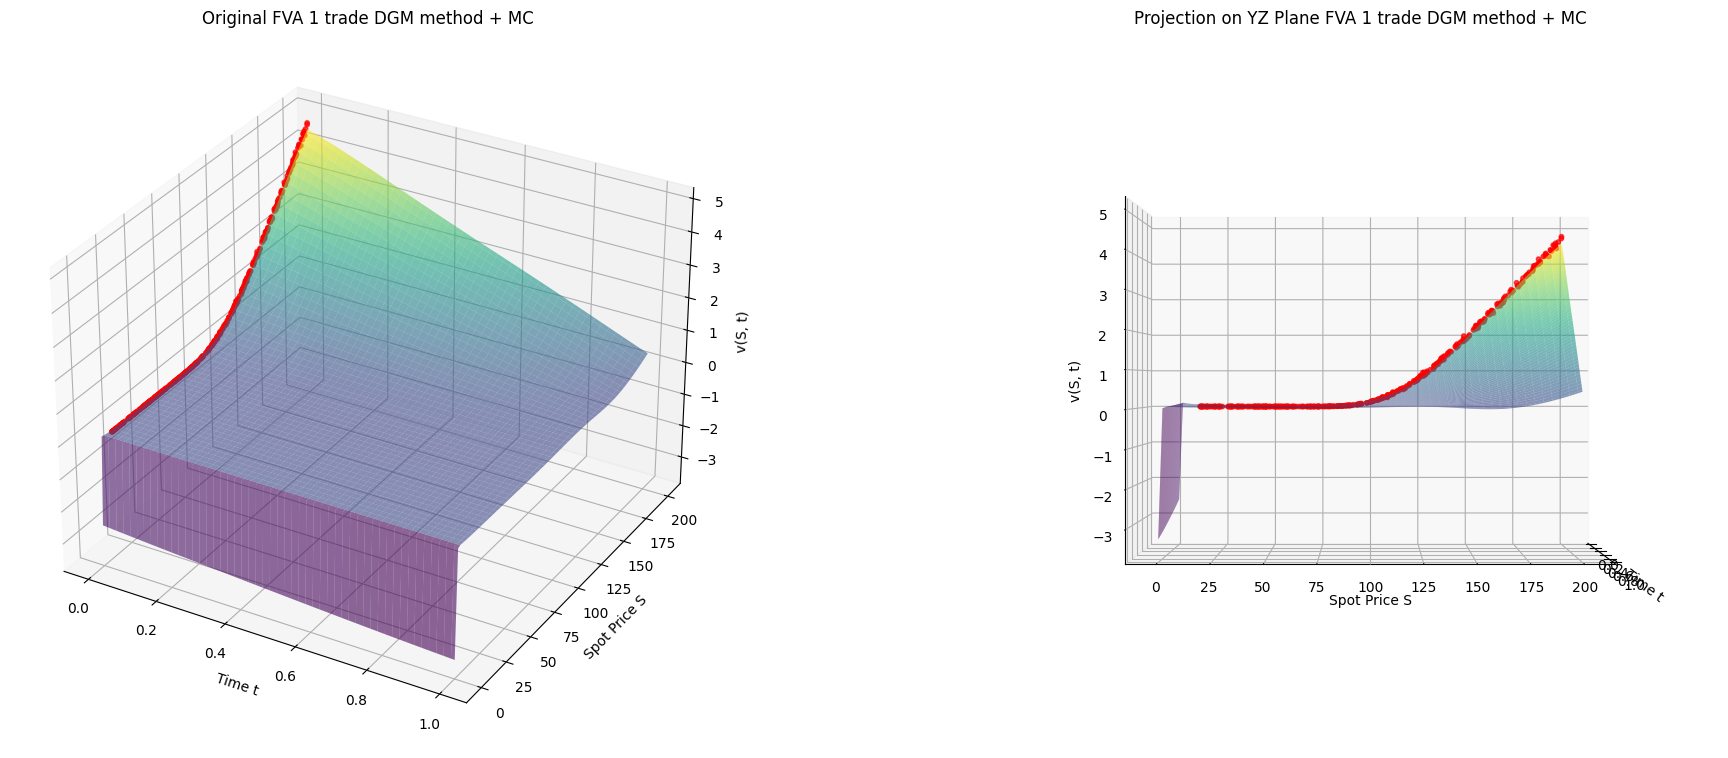

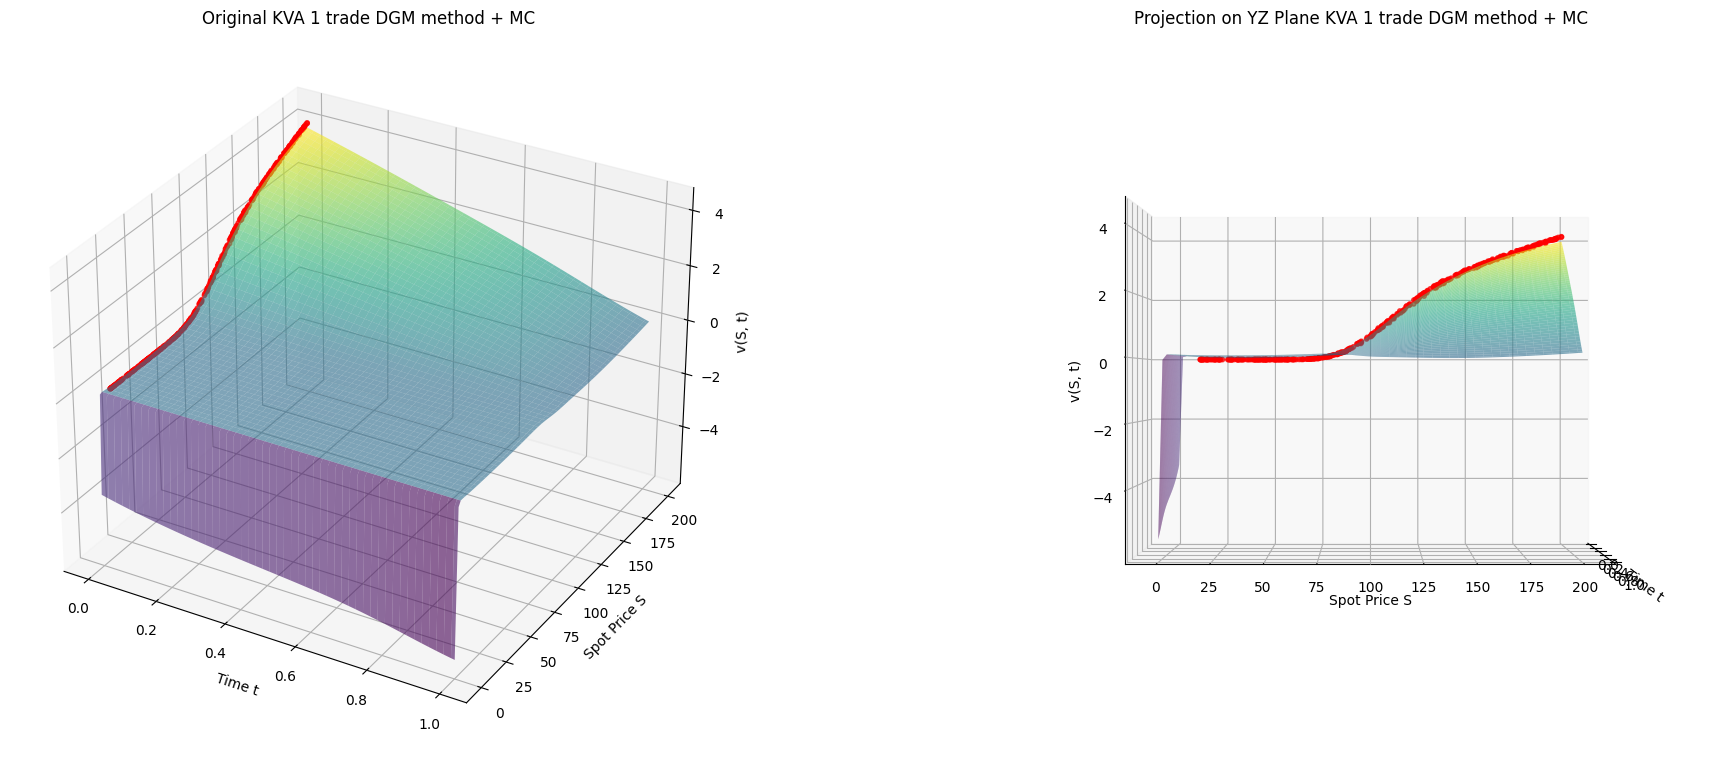

In [ ]:
FVA_MC = generatePayoffFVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('Spot Price S')
ax1.set_zlabel('v(S, t)')
ax1.set_title('Original FVA 1 trade DGM method + MC')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('v(S, t)')
ax2.set_title('Projection on YZ Plane FVA 1 trade DGM method + MC')

plt.tight_layout()
plt.show()







KVA_MC = generatePayoffKVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, w_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), KVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('Spot Price S')
ax1.set_zlabel('v(S, t)')
ax1.set_title('Original KVA 1 trade DGM method + MC')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, w_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), KVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('v(S, t)')
ax2.set_title('Projection on YZ Plane KVA 1 trade DGM method + MC')

plt.tight_layout()
plt.show()







<h3> Cas $\alpha=0.9 $ pour $w_{3}$ et $ v_{3}$ </h3>

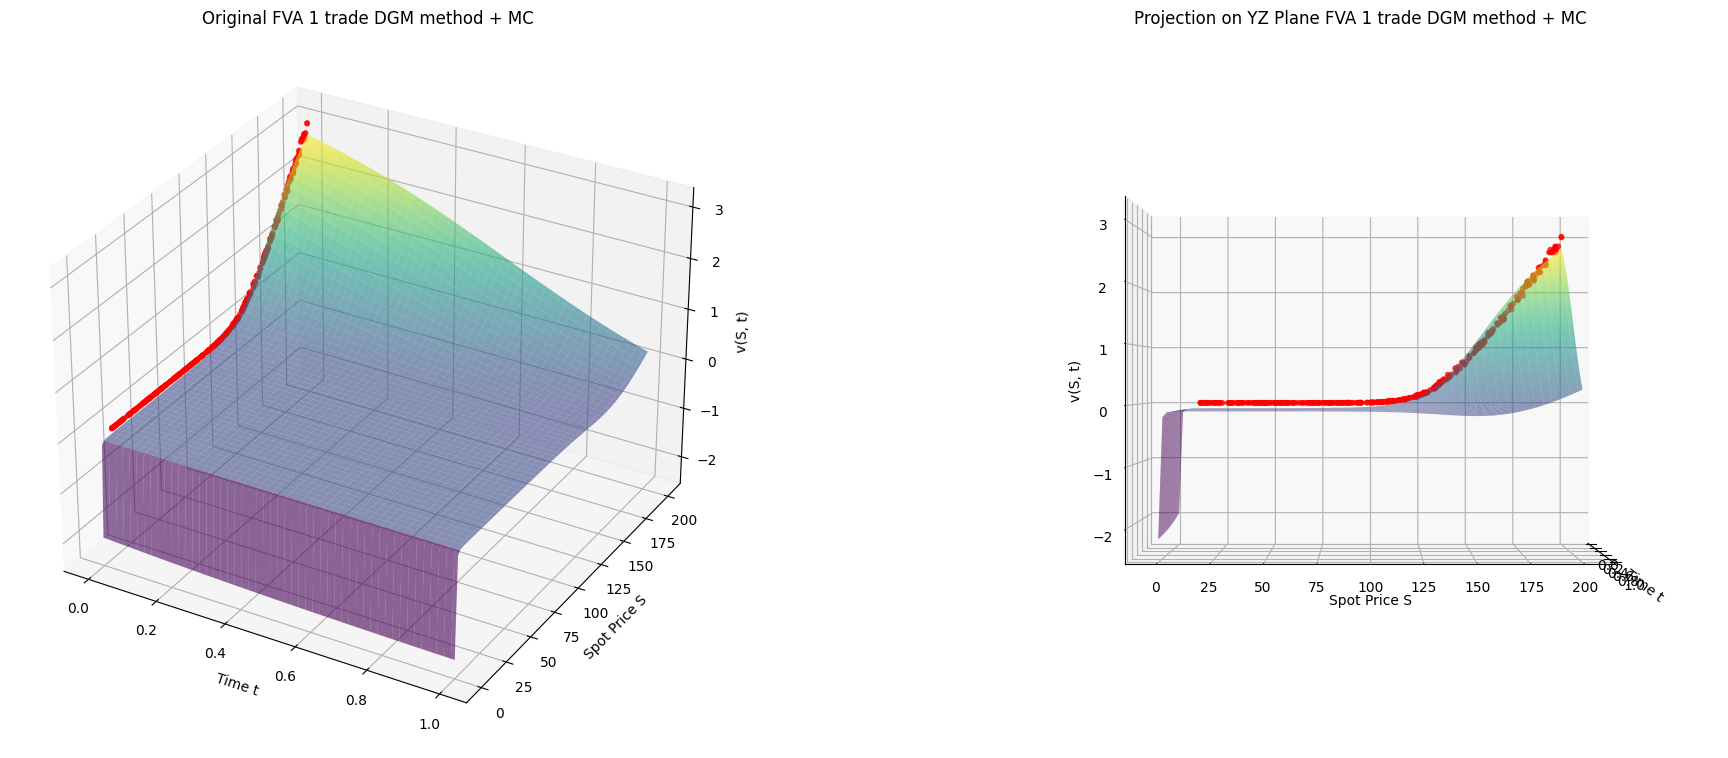

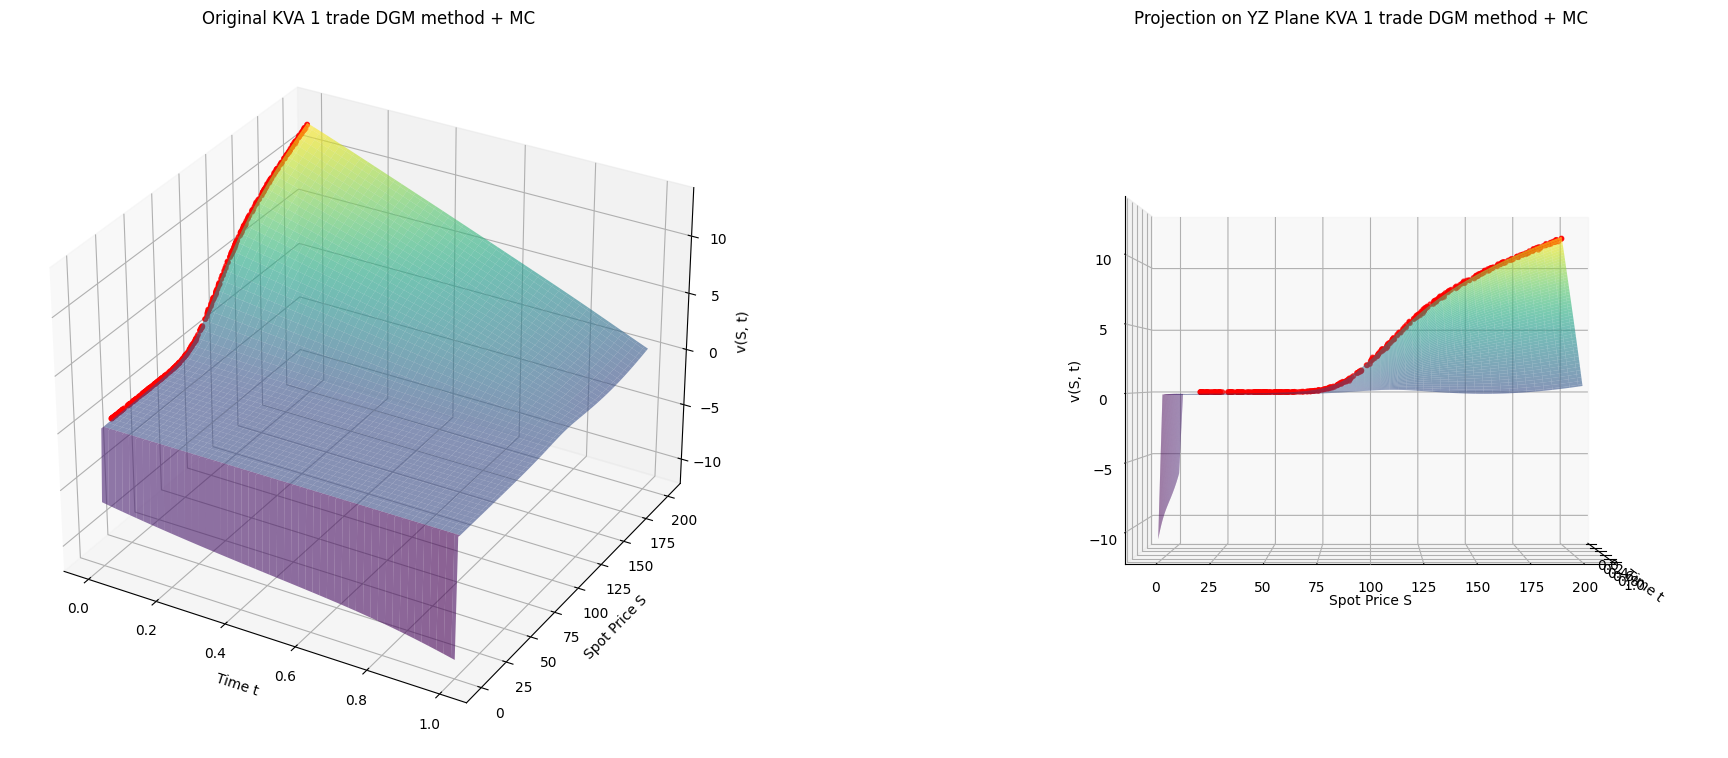

In [ ]:
FVA_MC = generatePayoffFVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('Spot Price S')
ax1.set_zlabel('v(S, t)')
ax1.set_title('Original FVA 1 trade DGM method + MC')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('v(S, t)')
ax2.set_title('Projection on YZ Plane FVA 1 trade DGM method + MC')

plt.tight_layout()
plt.show()







KVA_MC = generatePayoffKVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, w_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), KVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('Spot Price S')
ax1.set_zlabel('v(S, t)')
ax1.set_title('Original KVA 1 trade DGM method + MC')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, w_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), KVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('v(S, t)')
ax2.set_title('Projection on YZ Plane KVA 1 trade DGM method + MC')

plt.tight_layout()
plt.show()







<h3> Cas $\alpha=0.9$  pour $w$ et $v$ </h3>

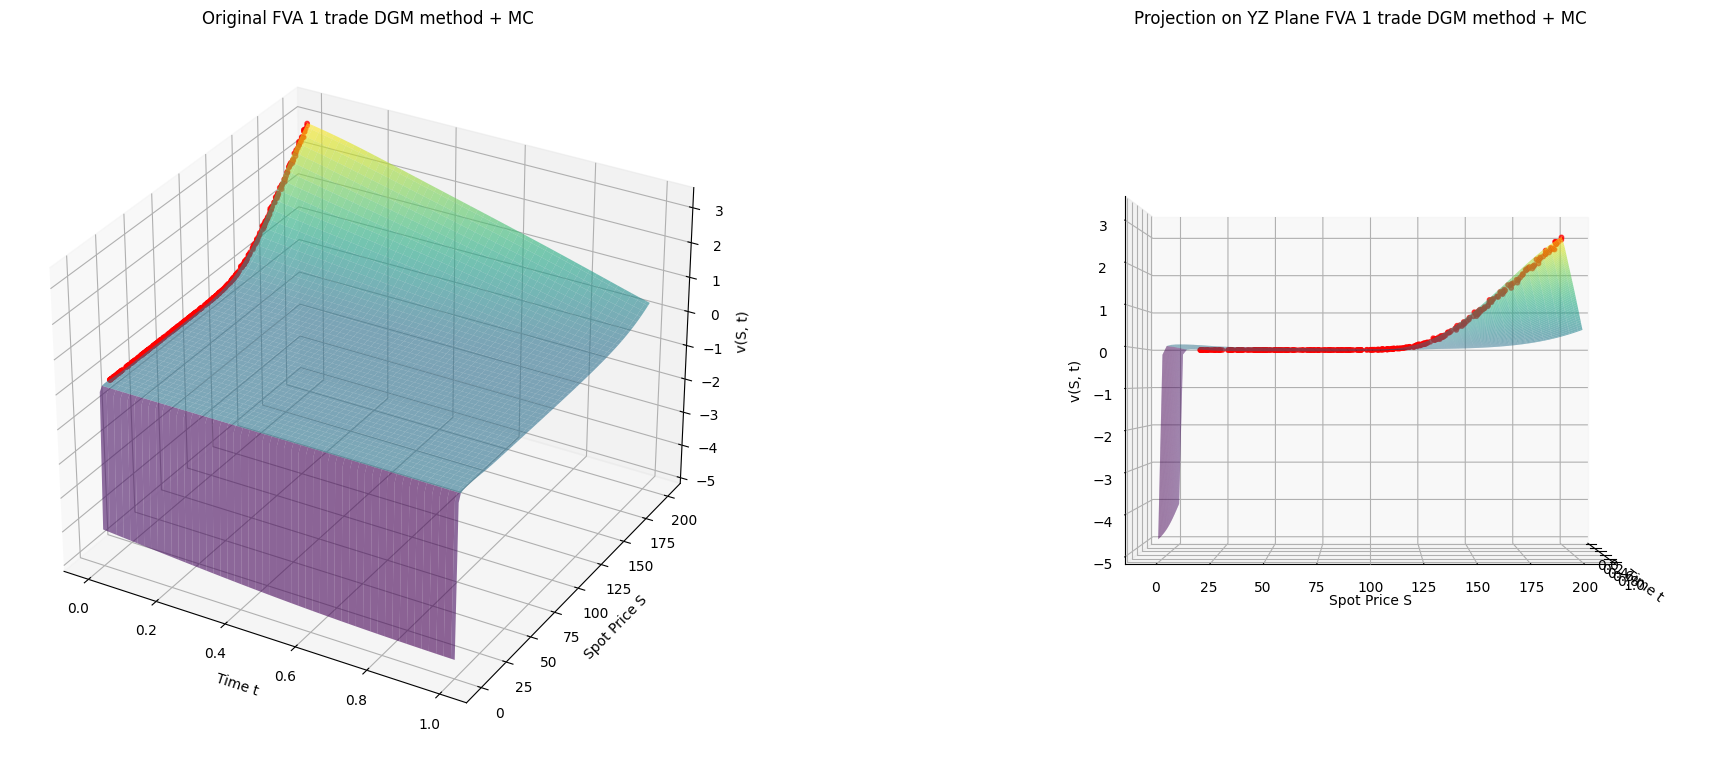

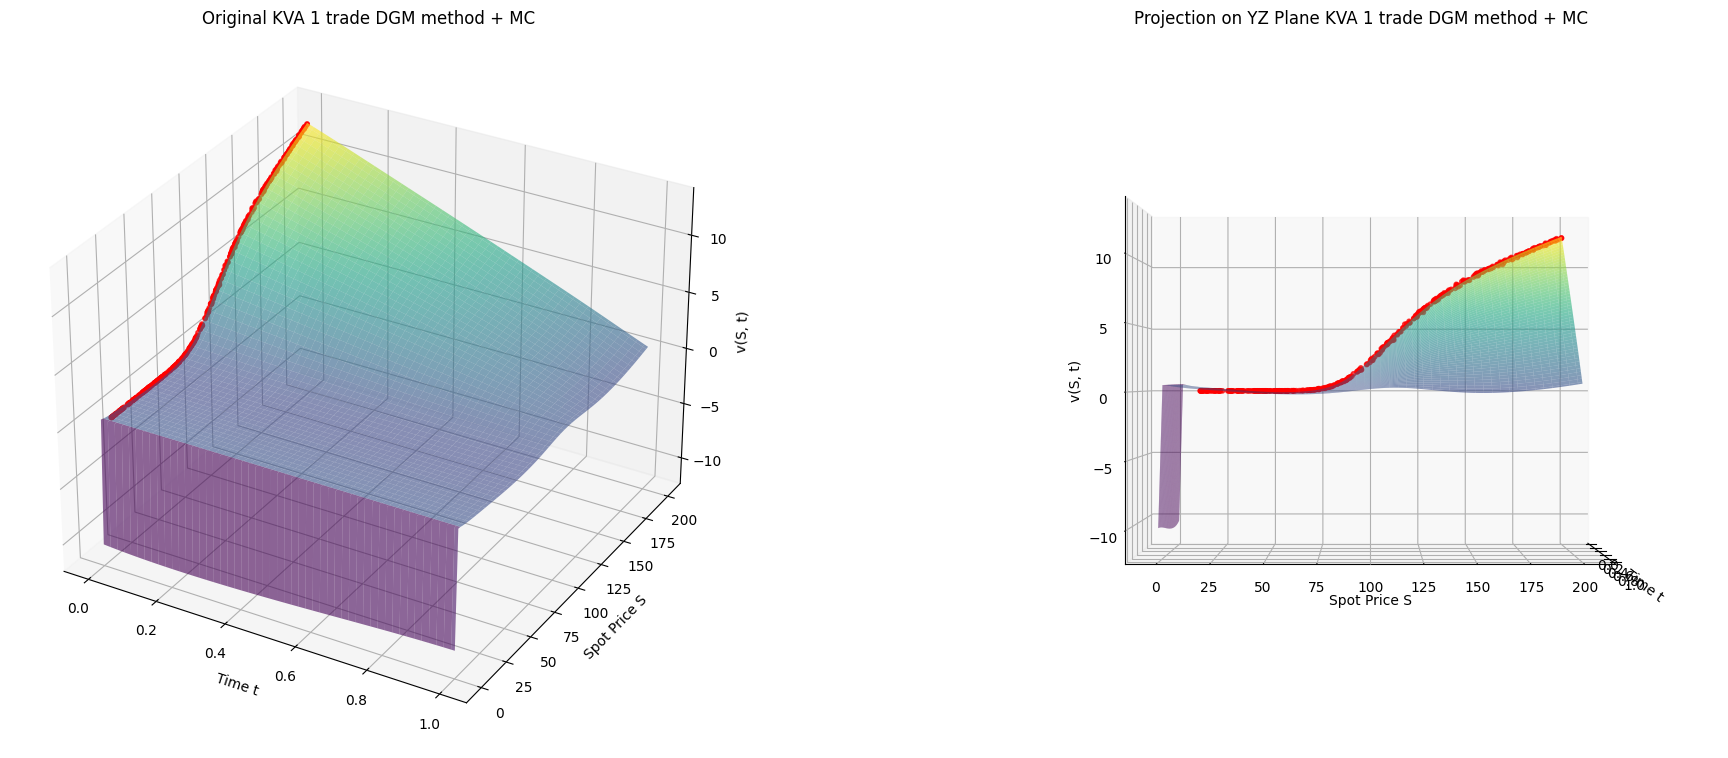

In [ ]:
FVA_MC = generatePayoffFVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('Spot Price S')
ax1.set_zlabel('v(S, t)')
ax1.set_title('Original FVA 1 trade DGM method + MC')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('v(S, t)')
ax2.set_title('Projection on YZ Plane FVA 1 trade DGM method + MC')

plt.tight_layout()
plt.show()







KVA_MC = generatePayoffKVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, w_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), KVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('Spot Price S')
ax1.set_zlabel('v(S, t)')
ax1.set_title('Original KVA 1 trade DGM method + MC')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, w_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), KVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('v(S, t)')
ax2.set_title('Projection on YZ Plane KVA 1 trade DGM method + MC')

plt.tight_layout()
plt.show()







<h3> Cas $\alpha=0.3$  pour $w$ et $v$ </h3>

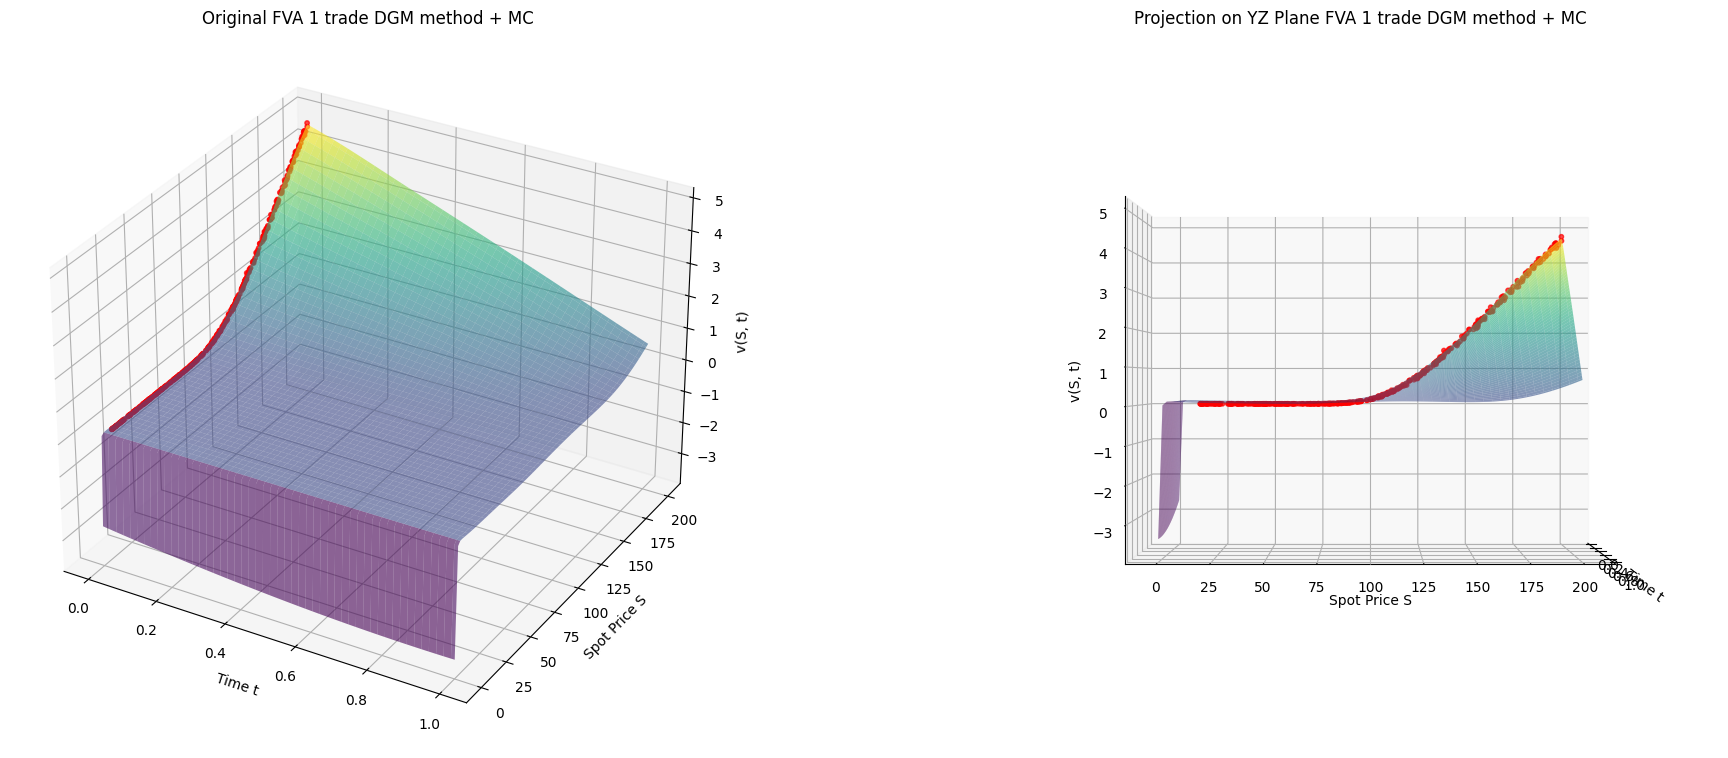

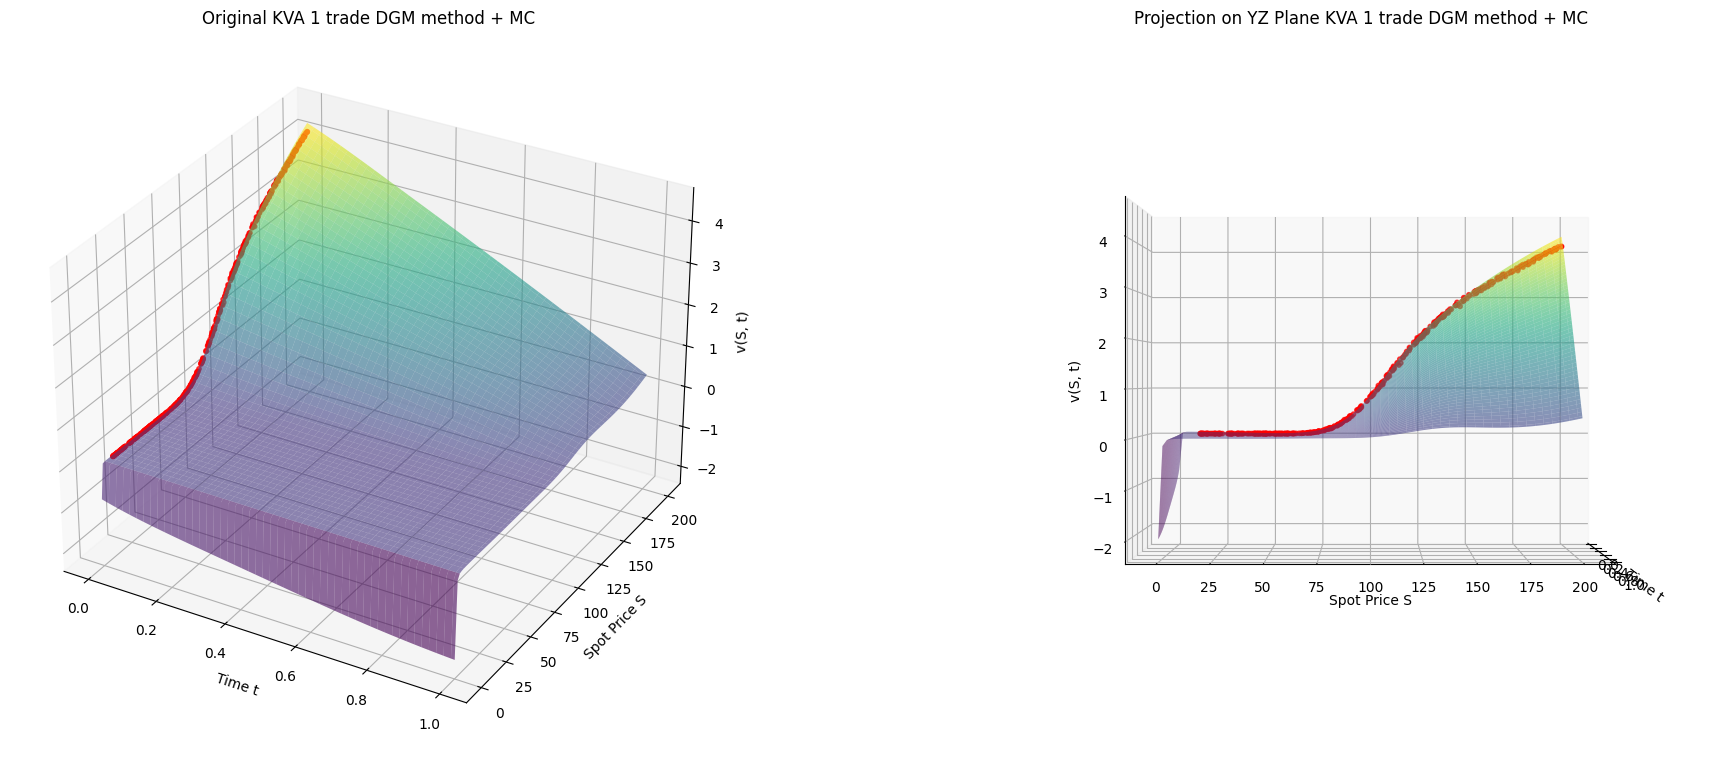

In [ ]:
FVA_MC = generatePayoffFVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('Spot Price S')
ax1.set_zlabel('v(S, t)')
ax1.set_title('Original FVA 1 trade DGM method + MC')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), FVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('v(S, t)')
ax2.set_title('Projection on YZ Plane FVA 1 trade DGM method + MC')

plt.tight_layout()
plt.show()







KVA_MC = generatePayoffKVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, w_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), KVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('Spot Price S')
ax1.set_zlabel('v(S, t)')
ax1.set_title('Original KVA 1 trade DGM method + MC')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, w_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), KVA_MC[:, 0, 0], color='red', s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('v(S, t)')
ax2.set_title('Projection on YZ Plane KVA 1 trade DGM method + MC')

plt.tight_layout()
plt.show()







**Analyse des Résultats**  :      

- On remarque à l'aide de la méthode **Deep Galerkin** que les différences obtenus entre les EDPs les plus génériques et les EDPs les plus simples semblent être assez minimes c'est à dire que la complexification de l'EDP ne change pas fondamentalement les solutions des EDPs c'est pour celà qu'on n'a pas effectué toutes les analyses comme dans la première partie, les résultants étant similaires.

- On remarque comme prévu que la $KVA$ est une fonction croissante du paramètre de mis-hedge $\alpha$. De même, la $FVA$ est bien une fonction décroissante du paramètre $\alpha$ ( en testant pour $\alpha$=0.3 et $\alpha$=0.9).



<a name='section_bonus'></a>

**Partie Bonus : Etude de la méthode Deep BSDE Solver**


On va s'intéresser ici aux équations suivantes correspondant dans l'article


- $v_{1}(T,S)=w_{2}(T,S)=0  $ sur $]0, \infty[$
- $\frac{\partial{v_{1}}}{\partial{t}}+A^{bs}_{S}v_{1}+ \lambda(\alpha f \sigma S |\frac{\partial{v_{1}}}{\partial{S}}-\Delta_{bs}| + v_{1}-u_{bs})^{-}-rv=0$ sur $]0,T[x ]0,\infty[$
- $\frac{\partial{w_{2}}}{\partial{t}}+A^{bs}_{S}w_{2} + h max(\alpha f \sigma  S |\Delta_{bs}|,w_{2})-(r+h)w_{2}=0$  sur $]0,T[x ]0,\infty[$

**Idée de la Méthode :**


L'idée de la méthode Deep BSDE repose sur l'utilisation de la formule de Feyman-Kac non linéaire :

On peut utiliser une approche en réecrivant $w_{2}$ avec la forme Feymann-Kac non linéaire :


$Y_{t}=w_{2}(T,S) -\int_{t}^{T} f(s,S_{s},Y_{s},Z_{s}) ds + \int_{t}^{T} Z_{s} \cdot dW_{s}=- \int_{t}^{T} f(s,S_{s},Y_{s},Z_{s}) ds + \int_{t}^{T} Z_{s} \cdot dW_{s}$

Sous de bonnes hypothèse de régularité, on peut montrer que :

$Y_{s}=w_{2}(s,S_{s})$ ,  $f(s,S_{s},Y_{s},Z_{s})=h max(\alpha f \sigma S_{s} | \Delta^{bs}_{s}|,Y_{s})-(r+h)Y_{s}$  et $Z_{s}=\sigma S_{s} \frac{\partial{w}}{\partial{S}}(s,S_{s})$.



Comment peut-on approximer les quantités d'intérêt à savoir $Y_{0}$ et $Z_{0}$ ?

On va simuler le schéma de manière  forward en supposant que $Y_{0}$ et $Z_{0}$ sont des paramètres du réseau de neurones à estimer et le but va alors de minimiser la fonction de perte suivante :     $\mathbb{E}[|w_{2}(T,S_{T})-Y^{\theta}(T,S_{T})|^{2}]$ par rapport au paramètre $\theta$ où on va approximer $Y^{\theta}(T,S_{T})$ par un schéma d'Euler défini de la manière suivante :    $ Y^{\theta}_{t_{i+1}}=Y^{\theta}_{t_{i}} -(t_{i+1}-t_{i})f(t_{i},S_{t_{i}},Y_{t_{i}},Z_{t_{i}}) + Z_{t_{i}}(W_{t_{i+1}}-W_{t_{i}})$ en partant donc de $Y_{0}$ et de $Z_{0}$ qui sont des paramètres du réseau de neurones à estimer. On les initialise avec la fonction **torch.rand**.

On voit cependant qu'il faut également pouvoir estimer les quantités $Z_{t_{i}}$ dans le schéma de discrétisation. Pour se faire, les auteurs de l'article estiment chacun de ces paramètes par un réseau de neurones, c'est à dire que pour chaque pas de temps $t_{i}$, ils estiment un réseau de neurones $U^{\theta}_{t_{i}}$ pour estimer $Z_{t_{i}}$ avec en input le processus forward $S_{t_{i}}$.

On obtient alors le schéma suivant suivant :

$ Y^{\theta}_{t_{i+1}}=Y^{\theta}_{t_{i}} -(t_{i+1}-t_{i})f(t_{i},S_{t_{i}},Y^{\theta}_{t_{i}},U^{\theta}_{t_{i}}) + U^{\theta}_{t_{i}}(S_{t_{i}})(W_{t_{i+1}}-W_{t_{i}})$ et on minimise  $\mathbb{E}[|Y^{\theta}(T,S_{T})|^{2}]$





**Applications :**

On donne ci-dessous le code que nous avons utilisé mais qui n'a pas donné de résultats satisfaisant car nous avons remarqué des problèmes de stabilité pour le réseau de neurones bien qu'il semble s'approcher de la bonne valeur "théorique".



In [ ]:
class DeepBSDE(nn.Module):
    def __init__(self, t0=0.0,
                 t1=1.0,
                 dim=1,
                 time_steps=50,
                 sigma=0.2,
                 learning_rate=1e-3,
                 num_hidden_layers=2,
                 num_neurons=100,
                 r=0.02,
                 S0=100):
        super().__init__()

        self.t0 = t0
        self.t1 = t1
        self.N = time_steps
        self.dim = dim
        self.r = r
        self.sigma = sigma
        self.x = S0 * torch.ones(self.dim)
        self.dt = (t1 - t0) / (self.N)
        self.sqrt_dt = torch.sqrt(torch.tensor(self.dt))

        self.t_space = torch.linspace(self.t0, self.t1, self.N + 1)[:-1]

        # Initialize value and gradient of u(t_0,X_{t_0}) by zeros ( correspondant ici à Y_{0} et Z_{0})
        self.u0 = nn.Parameter(torch.rand(1) * 1)
        self.gradu0 = nn.Parameter(torch.rand(1, dim) * 0.2 - 0.1)


        # Set optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, eps=1e-8)

        # Initialize a list of networks approximating the gradient of u(t, x) at t_i
        self.gradui = nn.ModuleList()

        # Create template of dense layer without bias and activation
        _dense = lambda dim: nn.Linear(dim, dim, bias=False)

        # Create template of batch normalization layer
        _bn = lambda: nn.BatchNorm1d(dim, momentum=0.99, eps=1e-6)


        # Loop over number of time steps
        for _ in range(self.N - 1):
            # Batch normalization on dim-dimensional input
            this_grad = nn.Sequential(nn.BatchNorm1d(dim))

            # Hidden layers of type (Dense -> Batch Normalization -> ReLU)
            for _ in range(num_hidden_layers):
                this_grad.add_module('dense',nn.Linear(dim,num_neurons,bias=False))
                this_grad.add_module('bn',nn.BatchNorm1d(num_neurons,momentum=0.99,eps=1e-6))

                this_grad.add_module('relu', nn.ReLU())
            # Dense layer followed by batch normalization for output
            this_grad.add_module('dense_output', nn.Linear(num_neurons,dim,bias=False))
            this_grad.add_module('bn_output', _bn())
            self.gradui.append(this_grad)

    def draw_X_and_dW(self, num_sample):
        # Draw increments of Brownian motion
        dW = torch.normal(mean=0.0, std=self.sqrt_dt, size=(num_sample, self.dim, self.N))

        # Initialize and set array of paths
        X = torch.zeros((num_sample, self.dim, self.N + 1))

        X[:, :, 0] = self.x.repeat(num_sample, 1)

        for i in range(self.N):
            # This corresponds to the Euler-Maruyama Scheme
            X[:, :, i + 1] = X[:, :, i] + X[:,:,i]*(self.r)*self.dt + self.sigma * X[:, :, i] * dW[:, :, i]
        # Return simulated paths as well as increments of Brownian motion
        return X, dW

    def forward(self, inp):
        X, dW = inp
        num_sample = X.size(0)

        e_num_sample = torch.ones(num_sample, 1)

        # Value approximation at t0
        y = e_num_sample * self.u0

        # Gradient approximation at t0
        z = e_num_sample.mm(self.gradu0)

        for i in range(self.N - 1):
            t = self.t_space[i]

            # Optimal control is attained by gradient
            eta1 = -self.fun_f(t, X[:, :, i], y, z) * self.dt
            eta2 = torch.sum(z * dW[:, :, i], dim=1, keepdim=True)

            y = y + eta1 + eta2

            # New gradient approximation
            # The division by self.dim acts as a stabilizer
            z = self.gradui[i](X[:,:,i+1])/(self.dim)

        # Final step
        eta1 = -self.fun_f(self.t_space[self.N - 1], X[:, :, self.N - 1], y, z) * self.dt
        eta2 = torch.sum(z * dW[:, :, self.N - 1], dim=1, keepdim=True)

        y = y + eta1 + eta2

        return y

    def loss_fn(self, inputs):
        X, _ = inputs

        # Forward pass to compute value estimates
        y_pred = self.forward(inputs)

        # Exact values at final time
        y = self.fun_g(X[:, :, -1])


        y_diff = y - y_pred
        loss = torch.mean(torch.square(y_diff),dtype=torch.float32)
        return loss

    def train_step(self, inp):
        self.optimizer.zero_grad()
        loss = self.loss_fn(inp)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def fun_f(self, t, x, y, z):
      pass
    def fun_g(self,x):
      pass


In [ ]:
model=DeepBSDE()


X,dW=model.draw_X_and_dW(10000)

X


tensor([[[100.0000, 102.8993, 105.6755,  ..., 145.1937, 151.3069, 148.0815]],

        [[100.0000, 100.5828, 100.6869,  ...,  92.4045,  88.3322,  85.3595]],

        [[100.0000, 101.3509, 101.4200,  ...,  67.7163,  65.2824,  67.4477]],

        ...,

        [[100.0000, 102.9631, 103.7804,  ...,  96.2958,  91.5727,  87.0357]],

        [[100.0000,  97.2854, 102.1477,  ..., 121.8050, 121.5904, 119.0462]],

        [[100.0000, 100.8458,  97.1705,  ..., 105.7535, 109.5394, 109.0484]]])

In [ ]:
from time import time
batch_size=500

def experiment(model, num_epochs=2000):
    # Initialize header
    print('  Iter        Loss        y   z[0]    L1_abs   |   Time  Stepsize')

    # Init timer and history list
    t0 = time()
    history=[]
    for i in range(num_epochs):

        inp = model.draw_X_and_dW(batch_size)
        loss = model.train_step(inp)
        # Get current Y_0 \approx u(0,x)
        y = model.u0.item()
        # Get current Z_0 \ approx delta
        z=model.gradu0.item()/(model.sigma*model.x[0].item())

        currtime = time() - t0
        #l1abs = np.abs(y - model.y_star)
        #l1rel = l1abs / model.y_star

        hentry = (i, loss, y,z, currtime, lr)
        history.append(hentry)
        if i%10 == 0:
            print('{:5d} {:12.4f} {:8.4f} {:8.4f} | {:6.1f}  {:6.2e}'.format(*hentry))
    return history


In [ ]:
class BlackScholesCall(DeepBSDE):
    def __init__(self,K=100, **kwargs):
        super().__init__(**kwargs)
        self.K=K

    # Running cost
    def fun_f(self, t, x, y, z):
        return -self.r*y
    # Terminal/Final cost
    def fun_g(self, x):
        K_int = torch.tensor(self.K, dtype=torch.float32)
        return torch.max(x - K_int, torch.tensor(0.0, dtype=torch.float32))



class BlackScholesPower(DeepBSDE):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    # Running cost
    def fun_f(self, t, x, y, z):
        return -self.r*y

    # Terminal/Final cost
    def fun_g(self, x):
        return torch.pow(x,1)


class FVA(DeepBSDE):
  pass

class KVA(DeepBSDE):
    def __init__(self,alpha=0.3,f=1.2,h=0.1,**kwargs):
        super().__init__(**kwargs)
        self.alpha=alpha
        self.f=f
        self.h=h


    def fun_f(self, t, x, y, z):
        #1er Trade Ici delta=CallTrade(110,1,3).delta(x,t)
        delta=CallTrade(110,1,3).delta(x,t)
        #return self.h*self.alpha*self.sigma*self.f*x*delta-(self.r+self.h)*y
        return self.h * torch.maximum(self.alpha * self.f * self.sigma * x*delta, y) - (self.r + self.h) * y

    def fun_g(self, x):
        return torch.tensor(0.0, dtype=torch.float32)


In [ ]:
num_exp = 1
batch_size = 500
lr = 1e-2
dim = 1
History = []
prob_id = 3
num_neurons = 300
num_hidden_layers = 5
num_time_steps = 50
suffix = '5layers'


for j in range(num_exp):
    print('{:s}\nStart of run {:d}\n{:s}'.format(70*'-',j+1,70*'-'))

    # Experiment 1: Black_Scholes
    model = KVA(t1=1, time_steps=30,
                            dim=dim,
                            S0=100,alpha=0.3,
                            learning_rate=lr,
                            num_neurons=num_neurons,
                            num_hidden_layers=num_hidden_layers)
    print(model.r)
    print(model.sigma)
    print(model.alpha)
    #print(model.K)
    print(model.x)
    print(model.N)
    print(model.t1)
    history = experiment(model, num_epochs=300)

    History.append(history) #1.6930 #2.35 pour 1 Trade

----------------------------------------------------------------------
Start of run 1
----------------------------------------------------------------------
0.02
0.2
0.3
tensor([100.])
30
1
  Iter        Loss        y   z[0]    L1_abs   |   Time  Stepsize
    0       1.1038   0.6185  -0.0027 |    0.1  1.00e-02


<ipython-input-1-828b4114071e>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.log(St/self.K) + (r + 0.5 * sigma**2) * torch.tensor(self.T-t)) / (sigma * torch.sqrt(torch.tensor(self.T-t)))


   10       1.3173   0.7098   0.0022 |    1.2  1.00e-02
   20       1.2332   0.7894   0.0069 |    2.4  1.00e-02
   30       1.3581   0.8309   0.0116 |    3.5  1.00e-02
   40       1.3927   0.8599   0.0157 |    4.3  1.00e-02
   50       1.4540   0.8493   0.0197 |    5.0  1.00e-02
   60       1.1355   0.8282   0.0233 |    5.7  1.00e-02
   70       1.3823   0.8143   0.0259 |    6.5  1.00e-02
   80       1.3006   0.8163   0.0276 |    7.4  1.00e-02
   90       1.3139   0.8121   0.0297 |    8.2  1.00e-02
  100       1.4571   0.8140   0.0315 |    9.0  1.00e-02
  110       1.5231   0.8264   0.0331 |    9.9  1.00e-02
  120       1.5425   0.8327   0.0349 |   10.6  1.00e-02
  130       1.5430   0.8305   0.0368 |   11.4  1.00e-02
  140       1.4611   0.8226   0.0380 |   12.1  1.00e-02
  150       1.3349   0.8224   0.0391 |   13.0  1.00e-02
  160       1.6200   0.8082   0.0402 |   14.0  1.00e-02
  170       1.4495   0.8180   0.0407 |   15.1  1.00e-02
  180       1.1872   0.8244   0.0407 |   16.3  1

In [ ]:
num_exp = 1
batch_size = 500
lr = 1e-1
dim = 1
History = []
prob_id = 3
num_neurons = 300
num_hidden_layers = 5
num_time_steps = 50
suffix = '5layers'


for j in range(num_exp):
    print('{:s}\nStart of run {:d}\n{:s}'.format(70*'-',j+1,70*'-'))

    # Experiment 1: Black_Scholes
    model = KVA(t1=1, time_steps=30,
                            dim=dim,
                            S0=100,alpha=0.3,
                            learning_rate=lr,
                            num_neurons=num_neurons,
                            num_hidden_layers=num_hidden_layers)
    print(model.r)
    print(model.sigma)
    print(model.alpha)
    #print(model.K)
    print(model.x)
    print(model.N)
    print(model.t1)
    history = experiment(model, num_epochs=300)

    History.append(history) #1.6930 #2.35 pour 1 Trade

----------------------------------------------------------------------
Start of run 1
----------------------------------------------------------------------
0.02
0.2
0.3
tensor([100.])
30
1
  Iter        Loss        y   z[0]    L1_abs   |   Time  Stepsize
    0       1.2916   0.8223   0.0021 |    0.1  1.00e-01


<ipython-input-1-828b4114071e>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.log(St/self.K) + (r + 0.5 * sigma**2) * torch.tensor(self.T-t)) / (sigma * torch.sqrt(torch.tensor(self.T-t)))


   10       1.3545   0.7485   0.0431 |    0.9  1.00e-01
   20       1.5100   0.8477   0.0589 |    1.6  1.00e-01
   30       1.3681   0.7504   0.0462 |    2.6  1.00e-01
   40       1.3148   0.8202   0.0406 |    3.6  1.00e-01
   50       1.4151   0.8729   0.0462 |    4.8  1.00e-01
   60       1.3361   0.7451   0.0440 |    5.7  1.00e-01
   70       1.3353   0.8713   0.0438 |    6.6  1.00e-01
   80       1.4520   0.7838   0.0458 |    7.5  1.00e-01
   90       1.2928   0.7688   0.0589 |    8.3  1.00e-01
  100       1.3066   0.9208   0.0524 |    9.1  1.00e-01
  110       1.3273   0.7240   0.0437 |    9.9  1.00e-01
  120       1.2394   0.8306   0.0519 |   10.7  1.00e-01
  130       1.2365   0.8231   0.0462 |   11.5  1.00e-01
  140       1.4225   0.8334   0.0419 |   12.3  1.00e-01
  150       1.2116   0.8491   0.0344 |   13.1  1.00e-01
  160       1.3830   0.8295   0.0519 |   13.9  1.00e-01
  170       1.3189   0.7887   0.0466 |   14.7  1.00e-01
  180       1.3233   0.8442   0.0426 |   15.7  1

<h3> BenchMark avec EDP Prix du Call pour vérifier la pertinence de la méthode utilisée </h3>

In [ ]:
# Code pour Benchmark par rapport à la valeur d'un Call :

lr = 1e-1
dim = 1
History = []
prob_id = 3
num_neurons = 300
num_hidden_layers = 5
num_time_steps = 50
suffix = '5layers'


for j in range(num_exp):
    print('{:s}\nStart of run {:d}\n{:s}'.format(70*'-',j+1,70*'-'))

    # Experiment 1: Black_Scholes
    model = BlackScholesCall(t1=1, time_steps=30,
                            dim=dim,
                            S0=100,
                            learning_rate=lr,
                            num_neurons=num_neurons,
                            num_hidden_layers=num_hidden_layers)
    print(model.r)
    print(model.sigma)
    print(model.K)
    print(model.x)
    print(model.N)
    print(model.t1)
    history = experiment(model, num_epochs=300)

    History.append(history)

----------------------------------------------------------------------
Start of run 1
----------------------------------------------------------------------
0.02
0.2
100
tensor([100.])
30
1
  Iter        Loss        y   z[0]    L1_abs   |   Time  Stepsize
    0     333.3398   0.3352   0.0077 |    0.1  1.00e-01
   10     245.6681   1.3148   0.0537 |    1.0  1.00e-01
   20     248.2586   2.2809   0.1012 |    1.7  1.00e-01
   30     231.2800   3.2085   0.1479 |    2.4  1.00e-01
   40     230.1037   4.0741   0.1930 |    3.0  1.00e-01
   50     251.7595   4.8587   0.2326 |    3.7  1.00e-01
   60     226.1225   5.5500   0.2651 |    4.4  1.00e-01
   70     210.8014   6.1831   0.2978 |    5.1  1.00e-01
   80     226.9396   6.7358   0.3308 |    5.7  1.00e-01
   90     190.7434   7.1770   0.3613 |    6.4  1.00e-01
  100     160.6582   7.5346   0.3946 |    7.1  1.00e-01
  110     166.6155   7.8103   0.4265 |    7.7  1.00e-01
  120     218.6049   8.0490   0.4537 |    8.4  1.00e-01
  130     177.68

**Analyse des Résultats** :

- Il semble y avoir un problème de stabilité dans la méthode Deep BSDE qu'on ne sait pas vraiment expliquer même si on remarque que pour la valeur du Prix du Call donnée par la résolution de l'EDP reste autour vers la valeur théorique ($C_{Theoretical} \approx  8.92$ et $Delta_{Theoretical} \approx 0.58$)

- On a effectué cette approche juste afin d'illustrer l'utilisation de la méthode Deep BSDE et on remarque que la valeur obtenue est proche de $0.80$ la valeur obtenue [ici](#Outputs_KVA) ce qui est cohérent avec ce que nous avions obtenu avec la méthode Deep Galerkin qui montrait que les résultats étaient très similaires entre les différentes déclinaisons des EDPs.

In [125]:
h(torch.tensor(110),torch.tensor(100),torch.tensor(100),torch.tensor(120),torch.tensor(0.2),torch.tensor(1))

tensor(10.)

In [36]:
def h(S, S0, K, B, sigma,t):
    # Calcul de la partie positive
    #positive_part = torch.maximum(S - K, torch.tensor(0.0, device=S.device))
    positive_part = S-K
    # Fonction indicatrice
    #indicator = torch.where(S < B, torch.tensor(1.0, device=S.device), torch.tensor(0.0, device=S.device))
   
    # Terme exponentiel
    exp_term = torch.exp(-(2 * torch.log(B / S0) * torch.log(B / S)) / (sigma**2 * t))
    # Calcul de h(S, S0)
    h_value = positive_part # indicator # * (1 - exp_term)
    
    return h_value
   

Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\samy.mekkaoui\AppData\Local\Temp\ipykernel_16388\391294273.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.q* (St - self.K*torch.exp(torch.tensor(-r*(self.T-t))))


Epoch 0, Train Loss: 2883.3374, Val Loss: 2722.1714
Epoch 100, Train Loss: 133.7161, Val Loss: 94.8859
Epoch 200, Train Loss: 15.3526, Val Loss: 11.5605
Epoch 300, Train Loss: 20.1116, Val Loss: 41.1624
Epoch 400, Train Loss: 3.6795, Val Loss: 4.4982
Epoch 500, Train Loss: 2.4443, Val Loss: 2.3892
Epoch 600, Train Loss: 33.3252, Val Loss: 18.6537
Epoch 700, Train Loss: 27.2594, Val Loss: 26.4760
Epoch 800, Train Loss: 5.4541, Val Loss: 6.9043
Epoch 900, Train Loss: 4.3811, Val Loss: 4.1760
Epoch 1000, Train Loss: 3.4561, Val Loss: 3.6504
Epoch 1100, Train Loss: 54.7428, Val Loss: 19.1084
Epoch 1200, Train Loss: 0.9629, Val Loss: 1.2460
Epoch 1300, Train Loss: 6.7294, Val Loss: 3.9313
Epoch 1400, Train Loss: 37.7207, Val Loss: 47.9936
Epoch 1500, Train Loss: 6.9263, Val Loss: 8.5094
Epoch 1600, Train Loss: 6.9411, Val Loss: 16.8525
Epoch 1700, Train Loss: 1.9461, Val Loss: 0.8455
Epoch 1800, Train Loss: 2.0069, Val Loss: 5.3566
Epoch 1900, Train Loss: 1.2231, Val Loss: 1.7021
Epoch 1999

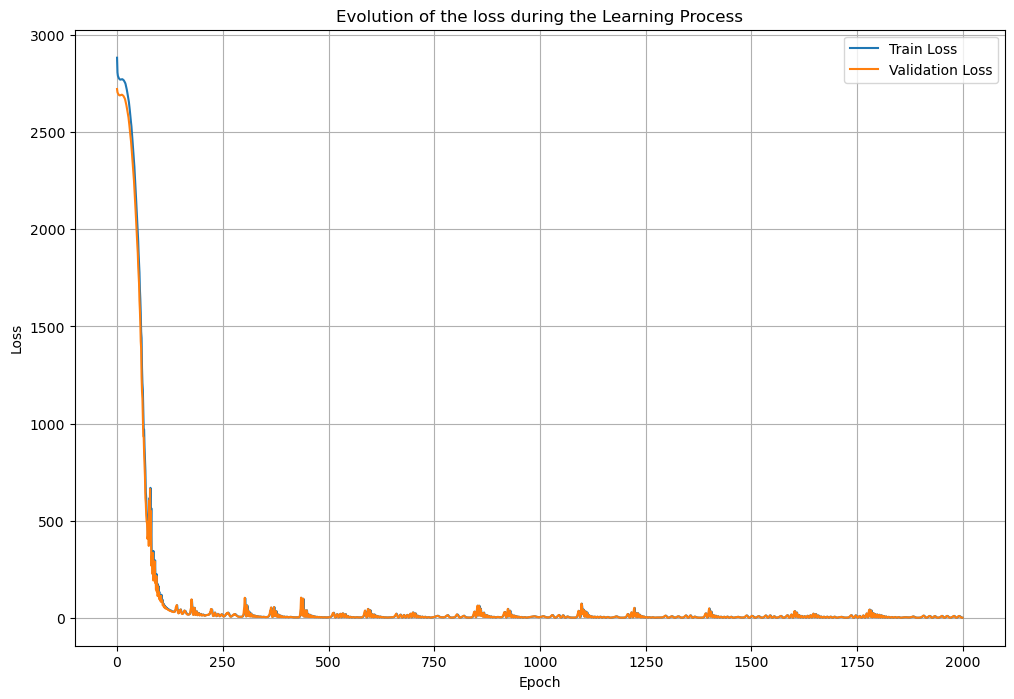

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
K=torch.tensor(100,dtype=torch.float32)
B=torch.tensor(150,dtype=torch.float32)
T_max = 1.0
S_max = 200.0
S_min = 20.0
num_t_points = 100
num_s_points = 100
batch_size = 1000  # Ajustez en fonction de la capacité de votre système
epochs = 2000
learning_rate = 1e-2
R=0
lambdaC=0.4
lambdaB=0.1
sb=0.02
sl=0.00

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définition des réseaux de neurones pour v et w
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.fc(x)

v_net = Net().to(device)
#w_net = Net().to(device)

# Fonction pour calculer les dérivées nécessaires
def compute_derivatives(net, S, T):
    S = S.requires_grad_()
    T = T.requires_grad_()
    net_input = torch.cat([T, S], dim=-1)
    output = net(net_input)
    output_grad = torch.autograd.grad(outputs=output, inputs=[T, S], grad_outputs=torch.ones_like(output),
                                      create_graph=True, allow_unused=True)
    d_output_dT = output_grad[0]
    d_output_dS = output_grad[1]

    # Ici, on recalcule output pour d_output_dS pour s'assurer que les gradients sont calculés correctement
    d2_output_dS2 = torch.autograd.grad(outputs=d_output_dS.sum(), inputs=S, create_graph=True)[0]

    return output, d_output_dT, d_output_dS, d2_output_dS2

# Fonction de perte
def loss_fn(S, T, v_net):
    v, dv_dt, dv_dS, d2v_dS2 = compute_derivatives(v_net, S, T)
    #w, dw_dt, dw_dS, d2w_dS2 = compute_derivatives(w_net, S, T)

    A_v = (r - q) * S * dv_dS + 0.5 * sigma ** 2 * S ** 2 * d2v_dS2
    #A_w = (r - q) * S * dw_dS + 0.5 * sigma ** 2 * S ** 2 * d2w_dS2

    prix_bs = portfolio2.trades[0].price(S, T)
    #delta_bs = portfolio.trades[0].delta(S, T)

    #V et W
    #loss_v = torch.mean((dv_dt + A_v + (1-R)*lambdaC*prix_bs - (r+lambdaC )* v)** 2) # CVA
    loss_v = torch.mean((dv_dt + A_v - r * v)** 2)
    #loss_w = torch.mean((dw_dt + A_w + h * torch.max(alpha * f * sigma * S * torch.abs(dv_dS - delta_bs), w) - (r + h) * w) ** 2)
    #V3 et W3
    terminal_condition_v = h(S, S, K, B, sigma,T)  # x_0 = S


    """
    loss_v = torch.mean((dv_dt + A_v + lambda_param * torch.abs((alpha * f * sigma * S * torch.abs(delta_bs) - prix_bs).clamp(max=0)) - r * v) ** 2)
    loss_w = torch.mean((dw_dt + A_w + h * alpha * f * sigma * S * torch.abs(delta_bs) - (r + h) * w) ** 2)
    """

    # Conditions terminales
    loss_terminal_v = torch.mean(((v_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1))-terminal_condition_v) ** 2))
    #loss_terminal_w = torch.mean((w_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1)) ** 2))

    return loss_v  + loss_terminal_v

# Préparation des données
T = torch.linspace(0.01, T_max, num_t_points).to(device)
S = torch.linspace(S_min, S_max, num_s_points).to(device)
T_grid, S_grid = torch.meshgrid(T, S, indexing='ij')
T_flat = T_grid.flatten().unsqueeze(1)  # Vecteur colonne
S_flat = S_grid.flatten().unsqueeze(1)  # Vecteur colonne

# Division en ensembles d'entraînement et de validation
indices = torch.randperm(T_flat.size(0))
train_indices = indices[:int(0.8 * len(indices))]
val_indices = indices[int(0.8 * len(indices)):]

T_train, S_train = T_flat[train_indices], S_flat[train_indices]
T_val, S_val = T_flat[val_indices], S_flat[val_indices]

# Optimiseurs
optimizer = optim.Adam(list(v_net.parameters()), lr=learning_rate)

# Entraînement
train_losses = []
val_losses = []

from tqdm.notebook import tqdm

# Boucle d'entraînement avec tqdm
for epoch in tqdm(range(epochs), desc="Training Progress"):
    optimizer.zero_grad()
    loss_train = loss_fn(S_train, T_train, v_net)
    loss_train.backward()
    optimizer.step()

    # Validation
    loss_val = loss_fn(S_val, T_val, v_net)

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())

    # Affichage périodique dans la barre de progression
    if epoch % 100 == 0 or epoch == epochs - 1:
        tqdm.write(f"Epoch {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")

# Tracé des courbes de perte
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Evolution of the loss during the Learning Process")
plt.legend()
plt.grid()
#plt.savefig("Images/TraingAndLossTestFVAFunctionlambdaC0.4lambdaB0.1sb0.02sl0.png")
plt.show()


In [41]:
# Basic Monte-Carlo Forward Vectorized
def generatePayoffFVAForwardVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_vec, r, sigma, alpha, h, f):
    Tmax = portfolio.trades[n_trades - 1].T
    grid = np.linspace(0, Tmax, N)
    pas = Tmax/N
    S_values = generate_BS_paths_Vectorized(mc_iterations, N, S0_vec, r, h, sigma, Tmax)
    sums = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)

    for index, s in (enumerate(grid)):
        Ss = S_values[:, :, index]
        prixBS = torch.zeros(S_values.shape[0], mc_iterations, n_trades, 1)

        for i in range(n_trades):
            for j in range(i + 1):
                current_trade = portfolio2.trades[j]
                if s < current_trade.T:
                    prixBS[:, :, i] += current_trade.priceforward(Ss, 0)

        sums += prixBS

    sums *= pas
    integralvalue = torch.mean(sums, dim=1)
    return integralvalue


In [44]:
S= torch.linspace(20,200,400)

prixBS=[]
for s in S0_val_vec :
    prixBS.append(CallTrade(100, 1,1).priceforward(s,0).item())

In [21]:
prixBS

[0.020126700401306152,
 0.0,
 0.0,
 63.26427459716797,
 51.5565185546875,
 0.5954561233520508,
 99.89437103271484,
 6.100875907577574e-06,
 98.31552124023438,
 3.4528884887695312,
 88.07908630371094,
 57.54425811767578,
 100.38750457763672,
 79.02493286132812,
 0.5476083755493164,
 0.004652239382266998,
 50.18970489501953,
 0.2873058319091797,
 0.0,
 22.443519592285156,
 12.95443344116211,
 20.19598388671875,
 4.806255340576172,
 58.44243621826172,
 96.85791778564453,
 43.41956329345703,
 7.1967926025390625,
 0.0,
 2.471942901611328,
 2.9697132110595703,
 13.252120971679688,
 5.914558410644531,
 74.23493194580078,
 0.014326304197311401,
 56.0028076171875,
 42.51200866699219,
 9.809368748392444e-07,
 22.869842529296875,
 1.2325153350830078,
 79.44805145263672,
 86.001953125,
 13.174980163574219,
 0.0,
 72.04006958007812,
 0.003548353910446167,
 0.0005260193720459938,
 23.75287628173828,
 6.094837188720703,
 43.310089111328125,
 65.41674041748047,
 0.0,
 32.440338134765625,
 0.0,
 2.7688

In [146]:
v_net(torch.tensor([0.0,150.0]))

tensor([51.5370], grad_fn=<ViewBackward0>)

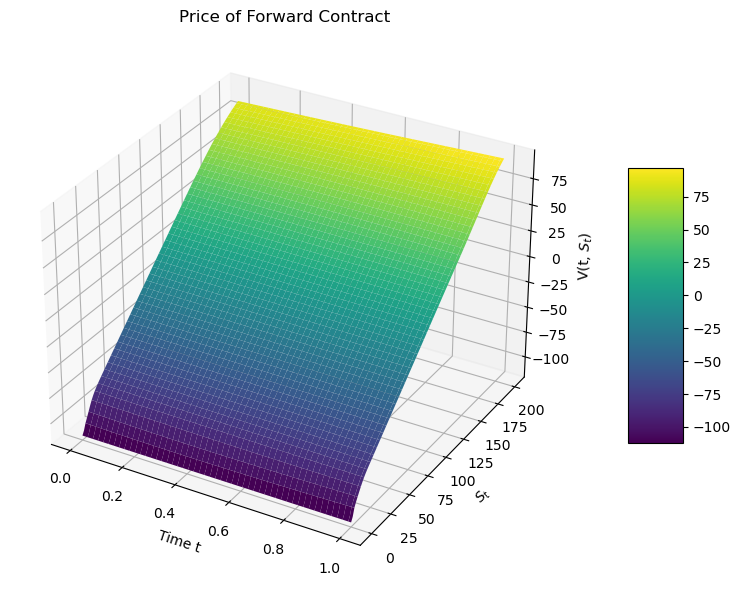

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assurez-vous que les modèles sont en mode évaluation
v_net.eval()
#w_net.eval()

# Génération de la grille de points
T_values = np.linspace(0, T_max, num_t_points)
S_values = np.linspace(0, S_max, num_s_points)
T_grid, S_grid = np.meshgrid(T_values, S_values)
points = torch.tensor(np.stack([T_grid.ravel(), S_grid.ravel()], axis=1), dtype=torch.float32).to(device)

# Évaluation des modèles
with torch.no_grad():
    v_pred = v_net(points).cpu().numpy().reshape(T_grid.shape)
    #w_pred = w_net(points).cpu().numpy().reshape(T_grid.shape)

# Tracé de v
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 1,1, projection='3d')
surf = ax.plot_surface(T_grid, S_grid, v_pred, cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('$S_t$')
ax.set_zlabel(' V(t, $S_t$)')
ax.set_title('Price of Forward Contract')
fig.colorbar(surf, shrink=0.5, aspect=5)

# Tracé de w
#ax = fig.add_subplot(1, 2, 2, projection='3d')
#surf = ax.plot_surface(T_grid, S_grid, w_pred, cmap='viridis')
#ax.set_xlabel('Time t')
#ax.set_ylabel('Spot Price S')
#ax.set_zlabel('w(S, t)')
#ax.set_title('w Function (KVA)')
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
#plt.savefig("Images/FVASurfaceProfilelambdaC0.4lambdaB0.1sb0.02sl0.00.png")
plt.show()

In [73]:
prixBS

[tensor([0.]),
 tensor([44.1807]),
 tensor([69.2880]),
 tensor([0.]),
 tensor([0.0042]),
 tensor([20.0671]),
 tensor([75.9168]),
 tensor([69.2880]),
 tensor([4.8453]),
 tensor([1.5804]),
 tensor([8.3995]),
 tensor([92.1425]),
 tensor([86.6703]),
 tensor([33.9150]),
 tensor([0.0006]),
 tensor([0.]),
 tensor([1.5083e-05]),
 tensor([0.]),
 tensor([45.0951]),
 tensor([55.3879]),
 tensor([2.1731e-05]),
 tensor([57.8285]),
 tensor([0.]),
 tensor([22.5378]),
 tensor([0.]),
 tensor([87.3969]),
 tensor([0.]),
 tensor([18.1898]),
 tensor([7.3116e-06]),
 tensor([30.3828]),
 tensor([3.3028e-06]),
 tensor([0.2500]),
 tensor([0.]),
 tensor([55.8332]),
 tensor([7.4936]),
 tensor([0.0269]),
 tensor([1.1659e-05]),
 tensor([0.4048]),
 tensor([55.6348]),
 tensor([31.0464]),
 tensor([3.8071e-07]),
 tensor([0.]),
 tensor([0.3492]),
 tensor([0.]),
 tensor([0.]),
 tensor([72.6066]),
 tensor([13.1142]),
 tensor([2.4789]),
 tensor([89.2955]),
 tensor([26.6989]),
 tensor([20.9625]),
 tensor([0.]),
 tensor([33.4

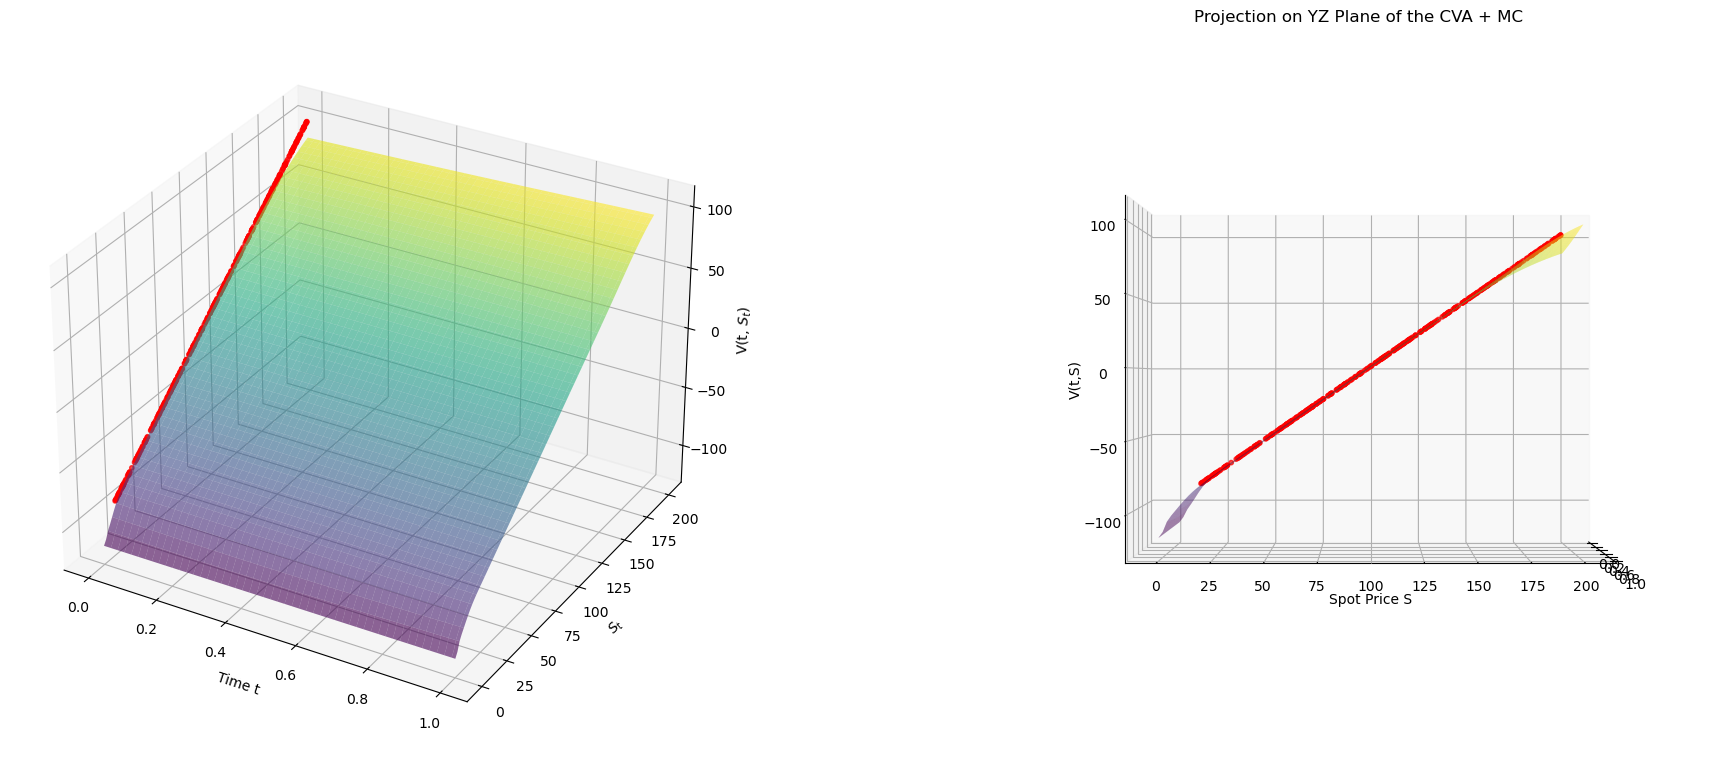

In [46]:

#CVA_MC = generatePayoffFVAVectorized_S0_Vectorized(mc_iterations, N, n_trades, S0_val_vec, r, sigma, alpha, h, f)
t_zeros = np.zeros_like(S0_val_vec.numpy())
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Graphique original en 3D
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax1.scatter(t_zeros, S0_val_vec.numpy(), prixBS, color='red', s=10, alpha=0.7)
ax1.set_xlabel('Time t')
ax1.set_ylabel('$S_t$')
ax1.set_zlabel('V(t, $S_t$)')
#ax1.set_title(' CVA with DGM Method + MC ')

# Projection sur YZ
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_grid, S_grid, v_pred, cmap='viridis', alpha=0.6)
ax2.scatter(t_zeros, S0_val_vec.numpy(), prixBS, color='red',s=10, alpha=0.7)
ax2.view_init(elev=0, azim=0)
#ax2.set_xlabel('aTime t')
ax2.set_ylabel('Spot Price S')
ax2.set_zlabel('V(t,S)')
ax2.set_title('Projection on YZ Plane of the CVA + MC ')
#labels = ["NN Output", "True Value of CVA with MC"]
plt.tight_layout()
#plt.savefig("Images/ProjectionCVAWithMClambdaC0.1.png")
plt.show()
